# Impact des ZFE sur le NO₂ à Grenoble et Paris   
Par Pierre-Andréa Silvente & Paolo Maunas – groupe X

## Introduction

Les zones à faibles émissions (ZFE) sont devenues un instrument central des politiques de lutte contre la pollution atmosphérique dans les grandes agglomérations françaises. Elles reposent sur des restrictions de circulation fondées sur les vignettes Crit’Air, avec pour objectif de réduire les émissions liées au trafic routier, en particulier pour le dioxyde d’azote (NO₂).

Mesurer l’effet réel de ces dispositifs n’est cependant pas immédiat. Les concentrations de NO₂ évoluent sous l’effet de nombreux facteurs : tendance de fond liée au renouvellement du parc automobile, conditions météorologiques, réorganisation du trafic, chocs exceptionnels comme la crise sanitaire de 2020, ou encore d’autres politiques publiques environnementales. Une simple comparaison « avant / après » l’introduction d’une ZFE ne permet donc pas d’attribuer de façon crédible une éventuelle baisse du NO₂ au seul dispositif.

Dans ce projet, nous cherchons à quantifier dans quelle mesure la mise en place des ZFE à Grenoble et à Paris s’est traduite par une diminution des concentrations de NO₂ au niveau de certaines stations urbaines. Le choix de ces deux villes permet de comparer l’effet d’un même type d’instrument dans un contexte de grande métropole (Paris) et dans une agglomération de taille plus modeste (Grenoble), tout en restant sur des territoires où le trafic routier est un enjeu important de qualité de l’air.

Pour cela, nous combinons plusieurs jeux de données open data :

- des données géographiques décrivant les périmètres de ZFE et leurs dates de mise en œuvre ;
- des séries journalières de NO₂ pour des stations situées à l’intérieur des ZFE de Grenoble et de Paris ;
- des séries comparables pour des stations d’autres grandes villes françaises, utilisées comme unités « donneuses » où aucune ZFE de même type n’a été mise en place sur la période étudiée.

Nous nous concentrons sur le NO₂ parmi les polluants disponibles sur les plateformes de surveillance (CO, benzène C₆H₆, NOₓ, O₃, SO₂, PM₁₀, etc.), car il s’agit de l’indicateur réglementaire le plus directement lié au trafic routier et celui pour lequel les dépassements des valeurs limites ont motivé la mise en place des ZFE. C’est aussi le polluant pour lequel la couverture spatiale et temporelle des stations est la plus homogène dans nos données, ce qui facilite les comparaisons entre villes et la construction de contrefactuels.

La démarche repose sur trois blocs principaux :

1. une analyse descriptive des niveaux de NO₂ avant et après la mise en place des ZFE, à Grenoble et à Paris, et leur comparaison avec les villes donneuses ;
2. un modèle de contrôle synthétique (avec pénalisation Ridge, Lasso et ElasticNet) pour construire, pour chaque station traitée, un contrefactuel « sans ZFE » à partir des donneurs ;
3. des modèles de machine learning (forêt aléatoire, gradient boosting) utilisés comme contrefactuels alternatifs.

L’objectif est de documenter, autant que possible, un impact causal de la mise en place des ZFE sur les concentrations de NO₂, à partir de données publiques. Nous mettons l’accent sur la reproductibilité de l’analyse et sur l’interprétation des ordres de grandeur obtenus. Lorsque les résultats sont faibles ou ambigus, nous cherchons à comprendre dans quelle mesure cela tient aux données disponibles, aux choix méthodologiques ou au fait que l’effet de la ZFE est lui-même limité.


## Sommaire

- [Installation et reproductibilité](#installation)
- [Préparation des données](#preparation-des-donnees)
  - [Adresses](#adresses)
  - [Données ZFE](#donnees-zfe)
  - [Données de pollution à Grenoble](#donnees-grenoble)
  - [Données de pollution à Paris](#donnees-paris)
  - [Donneurs : sélection des villes et des stations](#donneurs)
  - [Gestion des valeurs manquantes](#valeurs-manquantes)
- [Analyse descriptive](#analyse-descriptive)
  - [Grenoble : stations Les Frênes et Boulevards](#desc-grenoble)
  - [Paris : stations Champs-Élysées et Les Halles](#desc-paris)
  - [Comparaison avec les villes donneuses](#desc-donneurs)
- [Modélisation par contrôle synthétique](#scm)
  - [Principe et mise en œuvre](#scm-principe)
  - [Résultats pour Grenoble](#scm-grenoble)
  - [Résultats pour Paris](#scm-paris)
- [Modélisation par méthodes de machine learning](#ml)
  - [Spécification et stratégie d’estimation](#ml-spec)
  - [Résultats pour Grenoble](#ml-grenoble)
  - [Résultats pour Paris](#ml-paris)
- [Discussion et limites](#discussion)
- [Conclusion et perspectives](#conclusion)


<a id="installation"></a>
## Installation et reproductibilité

Ce notebook est placé à la racine du dépôt Git. L’arborescence attendue est la suivante :

- `data/` : fichiers bruts (exports ATMO / Airparif, GeoJSON) et fichiers nettoyés utilisés dans le projet ;
- `scripts/` : fonctions génériques de préparation des données et de modélisation (`zfe_data.py`, `build_pollution_data.py`, `data_prep.py`, `scm_models.py`, `ml_models.py`) ;
- `main.ipynb` : notebook principal qui contient le rapport et le code permettant de reproduire les résultats.

Les scripts du dossier `scripts/` permettent de reconstruire tous les fichiers intermédiaires à partir des données brutes. Pour faciliter la reproductibilité sur une instance vierge (par exemple sur le SSP Cloud), nous conservons également dans `data/` les fichiers nettoyés utilisés dans la suite du notebook. Il est donc possible :

- soit de relancer l’intégralité de la chaîne (reconstruction des tables ZFE, nettoyage des exports de pollution, etc.) ;
- soit de repartir directement des fichiers `*_clean.csv` fournis, ce qui raccourcit l’exécution.

Pour reproduire ce rapport à partir d’un environnement vierge :

1. Cloner le dépôt GitHub, puis se placer à la racine du projet (là où se trouve ce notebook).
2. Créer éventuellement un environnement virtuel Python et l’activer (recommandé, mais non obligatoire).
3. Installer les dépendances listées dans `requirements.txt` :

   ```bash
   pip install -r requirements.txt


In [83]:
from pathlib import Path
import pandas as pd
from sklearn.metrics import r2_score

# Dossier racine du projet = dossier contenant ce notebook
PROJECT_ROOT = Path().resolve()

DATA_DIR = PROJECT_ROOT / "data"
SCRIPTS_DIR = PROJECT_ROOT / "scripts"

print("Racine du projet      :", PROJECT_ROOT)
print("Dossier data          :", DATA_DIR)
print("Dossier scripts       :", SCRIPTS_DIR)

if not DATA_DIR.exists():
    raise FileNotFoundError(f"Le dossier data est introuvable : {DATA_DIR}")

if not SCRIPTS_DIR.exists():
    raise FileNotFoundError(f"Le dossier scripts est introuvable : {SCRIPTS_DIR}")

# Imports des fonctions utilitaires
from scripts.zfe_data import build_aires_voies_flat, build_zfe_clean_tables
from scripts.build_pollution_data import build_no2_with_zfe_flag
from scripts.data_prep import summarize_missing_daily, interpolate_daily_per_station
from scripts.scm_models import (
    fit_penalized_scm_monthly,
    fit_penalized_scm_daily,
    compute_att_summary, make_weights_tables
)
from scripts.ml_models import fit_ml_counterfactual_daily

Racine du projet      : C:\Users\Pierre\Desktop\Projet Python pour la Data Science
Dossier data          : C:\Users\Pierre\Desktop\Projet Python pour la Data Science\data
Dossier scripts       : C:\Users\Pierre\Desktop\Projet Python pour la Data Science\scripts


## Préparation des données <a id="preparation-des-donnees"></a>

### 1. Adresses <a id="adresses"></a>

Toutes les données utilisées dans ce projet proviennent de sources ouvertes. Pour assurer la reproductibilité, nous listons ici les principales URL d’origine (portails open data, export ATMO, etc.). Nous utiliserons une copie locale des fichiers bruts le dossier `data/`.

Les liens exacts vers les exports utilisés sont renseignés dans les variables ci-dessous. Ils ne sont pas exploités directement dans ce notebook, qui travaille à partir des fichiers bruts, mais ils documentent la provenance des données.

In [84]:
# Adresses des principales sources de données

ZFE_GEOJSON_AIRES_URL = "https://transport.data.gouv.fr/resources/79567"
ZFE_GEOJSON_VOIES_URL = "https://transport.data.gouv.fr/resources/79568"
ZFE_IDENTIFIANTS_URL = "https://transport.data.gouv.fr/resources/79760"  

MESURES_NO2_RAW_URL = "https://www.geodair.fr/donnees/export-advanced"


<a id="donnees-zfe"></a>

### 2. Données ZFE

Les périmètres de ZFE utilisés dans ce projet proviennent des fichiers GeoJSON publiés sur data.gouv et sont `aires.geojson` qui décrit les aires sur lesquelles la ZFE s’applique (polygones géographiques) ainsi que `voies.geojson` qui décrit les tronçons de voies concernés.

Chaque feature contient deux blocs d’information : un bloc `properties` avec des attributs géographiques et réglementaires et un bloc `publisher` qui décrit la ZFE et la collectivité (identifiant, nom, SIREN, forme juridique, etc.).

La table `zfe_ids.csv` également récupérée sur data.gouv fournit des informations supplémentaires par ZFE (SIREN, structure juridique, etc.).

Pour rendre ces données exploitables dans le reste du projet, nous avons mis en place le pipeline suivant, implémenté dans le script `scripts/zfe_data.py` :

1. **Aplatissement des GeoJSON**  
   Les fichiers `aires.geojson` et `voies.geojson` sont lus puis aplatis via la fonction `flatten_geojson`.  
   Chaque feature est transformée en une ligne, avec :
   - les champs de `properties` ;
   - les champs de `publisher` préfixés en `publisher_`.  
   Nous obtenons deux tables intermédiaires : `aires_flat.csv` et `voies_flat.csv`.

2. **Construction de tables nettoyées**  
   À partir de ces tables aplaties, nous sélectionnons des colonnes qui pourraient nous être pertinentes pour la suite de notre analyse. Donc : 
   - pour les aires : identifiant de ZFE, SIREN et nom de la collectivité, dates de début et de fin, informations sur les restrictions par type de véhicule (VP, VUL, poids lourds, bus, deux-roues), liens vers les arrêtés et sites d’information ;
   - pour les voies : mêmes informations ZFE/collectivité, plus les identifiants de tronçon (`osm_id`, `ref`, sens de circulation, indicateurs de dérogation, etc.).  
   Les dates de début et de fin sont converties au format `datetime`. Enfin, les résultats sont sauvegardés dans deux fichiers csv : `aires_clean.csv` et `voies_clean.csv`.

3. **Table de métadonnées `zfe_meta`**  
   À partir d’`aires_clean`, nous construisons une table de synthèse avec une ligne par ZFE (`publisher_zfe_id`, `publisher_siren`, `publisher_nom`).  
   Pour chaque ZFE, nous agrégons selon le processus suivant :
   - la première date de début observée dans les aires (`first_date_debut`) ;
   - la dernière date de début (`last_date_debut`) ;
   - la première date de fin si une fin est renseignée (`first_date_fin`) ;
   - le nombre d’aires couvertes (`n_aires`) ;
   - un indicateur de présence d’une restriction VP (`has_vp_restriction`).  

   Cette table est ensuite enrichie par jointure avec `zfe_ids.csv` sur le SIREN, afin de récupérer notamment la forme juridique et les informations complémentaires sur la collectivité. Le résultat final est sauvegardé sous le nom `zfe_meta.csv` et sert de table de référence pour identifier les ZFE de Grenoble et de Paris et leurs dates de mise en œuvre.

In [85]:
# Construction (ou reconstruction) de aires_flat et voies_flat à partir des GeoJSON
aires_flat, voies_flat = build_aires_voies_flat(
    data_dir=DATA_DIR,
    aires_geojson_name="aires.geojson",
    voies_geojson_name="voies.geojson",
    aires_flat_name="aires_flat.csv",
    voies_flat_name="voies_flat.csv",
)

print("aires_flat :", aires_flat.shape)
print("voies_flat :", voies_flat.shape)

# Construction des tables nettoyées et de zfe_meta
aires_clean, voies_clean, zfe_meta = build_zfe_clean_tables(
    data_dir=DATA_DIR,
    aires_flat_name="aires_flat.csv",
    voies_flat_name="voies_flat.csv",
    zfe_ids_name="zfe_ids.csv",
    aires_clean_name="aires_clean.csv",
    voies_clean_name="voies_clean.csv",
    zfe_meta_name="zfe_meta.csv",
)

print("aires_clean :", aires_clean.shape)
print("voies_clean :", voies_clean.shape)
print("zfe_meta    :", zfe_meta.shape)
print("Colonnes de zfe_meta :")
print(list(zfe_meta.columns))

zfe_meta.head(5)

aires_flat : (37, 47)
voies_flat : (8072, 32)
aires_clean : (37, 19)
voies_clean : (8072, 24)
zfe_meta    : (19, 13)
Colonnes de zfe_meta :
['publisher_zfe_id', 'publisher_siren', 'publisher_nom', 'first_date_debut', 'last_date_debut', 'first_date_fin', 'n_aires', 'has_vp_restriction', 'siren', 'code', 'epci_principal', 'autres_siren', 'forme_juridique']


,publisher_zfe_id,publisher_siren,publisher_nom,first_date_debut,last_date_debut,first_date_fin,n_aires,has_vp_restriction,siren,code,epci_principal,autres_siren,forme_juridique
0,ANGERS,244900015,CU Angers Loire Métropole,2025-01-01,2025-01-01,2026-12-31,1,True,244900015.0,ANGERS,Angers Loire Métropole,NaN,Métropole
1,ANNECY,200066793,CA du Grand Annecy,2025-01-01,2030-01-01,2027-12-31,4,True,200066793.0,ANNECY,Grand Annecy,NaN,Communauté d'agglomération
2,ANNEMASSE,200011773,CA Annemasse-Les Voirons-Agglomération,2025-01-01,2025-01-01,NaT,1,True,200011773.0,ANNEMASSE,Annemasse agglo,NaN,Communauté d'agglomération
3,BORDEAUX,243300316,Bordeaux Métropole,2025-01-01,2025-01-01,NaT,1,True,243300316.0,BORDEAUX,Bordeaux Métropole,NaN,Métropole
4,CLERMONT-FERRAND,246300701,Clermont Auvergne métropole,2023-07-01,2023-07-01,NaT,1,False,246300701.0,CLERMONT-FERRAND,Clermont Auvergne métropole,NaN,Métropole


In [86]:
filtre = zfe_meta[zfe_meta["publisher_zfe_id"].isin(["GRENOBLE", "PARIS"])]
filtre  

,publisher_zfe_id,publisher_siren,publisher_nom,first_date_debut,last_date_debut,first_date_fin,n_aires,has_vp_restriction,siren,code,epci_principal,autres_siren,forme_juridique
6,GRENOBLE,253800825,Syndicat Mixte des Mobilités de l'Aire Grenobl...,2019-05-02,2019-05-02,NaT,1,False,253800825.0,GRENOBLE,Grenoble Alpes métropole,NaN,Métropole
12,PARIS,217500016,Ville de Paris,2021-06-01,2021-06-01,NaT,1,True,217500016.0,PARIS,Ville de Paris,NaN,Autre collectivité territoriale


<a id="donnees-grenoble"></a> 
### 3. Données de pollution à Grenoble

Pour Grenoble, nous utilisons l’export brut fourni par ATMO Auvergne–Rhône-Alpes, couvrant plusieurs stations urbaines de l’agglomération, dont les deux stations que nous retenons pour l’analyse (*Les Frênes* et *Grenoble Boulevards*), toutes deux situées dans la ZFE. Le fichier contient notamment : une colonne d’horodatage (`Date de début`) qui date le début du prélèvement, le code et le nom de la station, le type d’implantation (urbaine, trafic, fond, etc.), le type d’influence, les coordonnées géographiques (latitude, longitude) et les concentrations journalières en NO₂, notre variable cible. Nous utilisons la période allant du 5 février 2016 au 5 février 2024, de manière à disposer d’un historique le plus long possible avant la mise en place de la ZFE (en 2019 pour Grenoble, d’après le tableau présenté plus haut).

Le traitement de cet export est implémenté dans la fonction générique `build_no2_with_zfe_flag` du module `scripts/build_pollution_data.py`, appelée avec `zfe_id="GRENOBLE"`. Cette fonction procède comme suit :

1. elle lit le fichier brut `Export Moy. journalière - 20251204215149 - 2016-02-05 00_00 - 2024-02-05 21_00.csv` et met en forme les colonnes de date, d’identifiant de station, de type d’implantation et d’influence, de coordonnées et de concentration en NO₂ ;
2. elle construit un jeu de données journalier au format interne du projet, avec les colonnes  
   `date`, `station_id`, `station_name`, `station_env`, `station_influence`, `no2_ug_m3`, `lat`, `lon`, ainsi qu’une étiquette de zone (`zone = "GRENOBLE"`), et sauvegarde le fichier `pollution_grenoble_no2_daily_clean.csv` dans le dossier `data/` ;
3. enfin, à partir d’`aires.geojson`, elle reconstruit la géométrie de la ZFE de Grenoble et calcule, pour chaque station, un indicateur d’appartenance au périmètre (`in_zfe_grenoble`). *PS : ce point avait déjà été vérifié au moment du choix des stations, mais rien ne vaut une cross-validation propre ;)*

Nous conservons `pollution_grenoble_no2_daily_clean.csv` comme base pour les analyses descriptives et les modèles sur Grenoble ; le tableau de métadonnées retourné par la fonction (et affiché dans le notebook) permet de vérifier que *Les Frênes* et *Grenoble Boulevards* ont bien `in_zfe_grenoble = True`.


In [87]:
# Nom du fichier brut pour la cible Grenoble
GRENOBLE_TARGET_RAW = (
    "Export Moy. journalière - 20251204215149 - 2016-02-05 00_00 - 2024-02-05 21_00.csv"
)

grenoble_no2_daily, grenoble_stations_meta = build_no2_with_zfe_flag(
    data_dir=DATA_DIR,
    raw_csv_name=GRENOBLE_TARGET_RAW,
    zfe_id="GRENOBLE",
    out_daily_name="pollution_grenoble_no2_daily_clean.csv",
    in_zfe_col="in_zfe_grenoble",
)

print("NO2 Grenoble (journalier, fichier cible) :", grenoble_no2_daily.shape)
display(grenoble_no2_daily.head())

print("Stations Grenoble (cible) et appartenance ZFE :")
display(
    grenoble_stations_meta[
        ["station_id", "station_name", "station_env", "station_influence", "in_zfe_grenoble"]
    ]
)

NO2 Grenoble (journalier, fichier cible) : (5836, 9)


,date,station_id,station_name,station_env,station_influence,no2_ug_m3,lat,lon,zone
0,2016-02-05,FR15043,Grenoble Les Frenes,Urbaine,Fond,27.0,45.1619,5.7356,GRENOBLE
1,2016-02-06,FR15043,Grenoble Les Frenes,Urbaine,Fond,17.0,45.1619,5.7356,GRENOBLE
2,2016-02-07,FR15043,Grenoble Les Frenes,Urbaine,Fond,15.0,45.1619,5.7356,GRENOBLE
3,2016-02-08,FR15043,Grenoble Les Frenes,Urbaine,Fond,26.0,45.1619,5.7356,GRENOBLE
4,2016-02-09,FR15043,Grenoble Les Frenes,Urbaine,Fond,15.0,45.1619,5.7356,GRENOBLE


Stations Grenoble (cible) et appartenance ZFE :


,station_id,station_name,station_env,station_influence,in_zfe_grenoble
0,FR15043,Grenoble Les Frenes,Urbaine,Fond,True
1,FR15046,Grenoble Boulevards,Urbaine,Trafic,True


<a id="donnees-paris"></a>
### 4. Données de pollution à Paris

Pour Paris, nous utilisons un export brut du réseau Airparif récupéré sur le site Geodair, couvrant plusieurs stations sur la période 2017–2025. La structure du fichier est similaire à celle de Grenoble : date de début de mesure, identifiant et nom de station, types d’implantation et d’influence, coordonnées géographiques et concentration journalière en NO₂.

Là encore, nous utilisons la fonction générique `build_no2_with_zfe_flag` du module `scripts/build_pollution_data.py`, cette fois avec `zfe_id="PARIS"`. La fonction :

1. lit le fichier `Export Moy. journalière - 20251205114649 - 2017-08-17 00_00 - 2025-12-04 11_00.csv` et le met au format standard du projet (colonnes `date`, `station_id`, `station_name`, `station_env`, `station_influence`, `no2_ug_m3`, `lat`, `lon`, `zone = "PARIS"`) ;
2. sauvegarde ce jeu de données dans le fichier `pollution_paris_no2_daily_clean.csv`, qui contient les séries journalières de NO₂ pour les stations parisiennes ;
3. reconstruit la géométrie de la ZFE Paris à partir d’`aires.geojson` et calcule, pour chaque station, un indicateur d’appartenance au périmètre (`in_zfe_paris`). Là aussi, le choix des stations avait été contrôlé à la main en amont, mais cette étape permet de formaliser la vérification dans le code.

Le fichier `pollution_paris_no2_daily_clean.csv` servira de base aux analyses descriptives et à la construction du contrôle synthétique pour Paris, tandis que la table des stations et de `in_zfe_paris` documente précisément les capteurs effectivement situés dans la zone régulée.


In [88]:
PARIS_RAW = "Export Moy. journalière - 20251205114649 - 2017-08-17 00_00 - 2025-12-04 11_00.csv"

paris_no2_daily, paris_stations_meta = build_no2_with_zfe_flag(
    data_dir=DATA_DIR,
    raw_csv_name=PARIS_RAW,
    zfe_id="PARIS",
    out_daily_name="pollution_paris_no2_daily_clean.csv",
    in_zfe_col="in_zfe_paris",
)

print("NO2 Paris (journalier) :", paris_no2_daily.shape)
display(paris_no2_daily.head())

print("Stations Paris (cible) et appartenance ZFE :")
display(
    paris_stations_meta[
        ["station_id", "station_name", "station_env", "station_influence", "in_zfe_paris"]
    ]
)

NO2 Paris (journalier) : (5268, 9)


,date,station_id,station_name,station_env,station_influence,no2_ug_m3,lat,lon,zone
0,2017-08-17,FR04031,Av Champs Elysees,Urbaine,Trafic,27.0,48.868772,2.311231,PARIS
1,2017-08-18,FR04031,Av Champs Elysees,Urbaine,Trafic,38.0,48.868772,2.311231,PARIS
2,2017-08-19,FR04031,Av Champs Elysees,Urbaine,Trafic,32.0,48.868772,2.311231,PARIS
3,2017-08-20,FR04031,Av Champs Elysees,Urbaine,Trafic,32.0,48.868772,2.311231,PARIS
4,2017-08-21,FR04031,Av Champs Elysees,Urbaine,Trafic,37.0,48.868772,2.311231,PARIS


Stations Paris (cible) et appartenance ZFE :


,station_id,station_name,station_env,station_influence,in_zfe_paris
0,FR04031,Av Champs Elysees,Urbaine,Trafic,True
1,FR04055,PARIS 1er Les Halles,Urbaine,Fond,True


<a id="donneurs"></a>
### 5. Donneurs : sélection des villes et des stations

Pour Grenoble, afin de par la suite construire un contrefactuel crédible concernant la pollution, nous avons besoin de stations donneuses situées dans des environnements urbains comparables, mais en dehors du périmètre de la ZFE grenobloise. L’idée est de disposer de villes proches géographiquement, soumises à des conditions météorologiques et à un contexte régional similaires, mais non traitées par la mesure.

Nous partons pour cela d’un export régional ATMO Auvergne–Rhône-Alpes couvrant plusieurs agglomérations de la région, sur la même période que Grenoble (2016–2024). Ce fichier brut (`Export Moy. journalière - 20251205011655 - 2016-02-05 00_00 - 2024-02-05 00_00.csv`) contient notamment des stations urbaines situées à Voiron, Gap, Chambéry, Valence, Romans-sur-Isère, Annecy, Bourgoin-Jallieu, en péréphérie de Grenoble ou encore Saint-Jean-de-Maurienne.

Le traitement suit exactement la même logique que pour Grenoble, en réutilisant la fonction générique `build_no2_with_zfe_flag` dans `scripts/build_pollution_data.py`, avec `zfe_id = "GRENOBLE"` :

1. l’export brut est mis au format standard du projet (colonnes `date`, `station_id`, `station_name`, `station_env`, `station_influence`, `no2_ug_m3`, `lat`, `lon`, `zone`) ;
2. la géométrie de la ZFE grenobloise est reconstruite à partir d’`aires.geojson` et, pour chaque station, un indicateur d’appartenance au périmètre est calculé (`in_zfe_grenoble`) ;
3. la table de métadonnées des stations retournée par la fonction nous permet ensuite de confirmer que l'on a bien `in_zfe_grenoble = False`. *(Même si bien sûr, ce point avit été vérifié avant !)*

Les identifiants de ces stations hors ZFE constituent notre **pool de donneurs** : nous extrayons les observations journalières correspondantes et les sauvegardons dans `no2_donors_grenoble_daily_clean.csv`. Ce fichier contient donc uniquement des séries de NO₂ issues de stations urbaines de la région, exposées à un contexte comparable à Grenoble mais non soumises à la ZFE.

In [89]:
# Nom du fichier brut pour les donneurs autour de Grenoble
GRENOBLE_DONORS_RAW = (
    "Export Moy. journalière - 20251205011655 - 2016-02-05 00_00 - 2024-02-05 00_00.csv"
)

donors_grenoble_daily, donors_grenoble_meta = build_no2_with_zfe_flag(
    data_dir=DATA_DIR,
    raw_csv_name=GRENOBLE_DONORS_RAW,
    zfe_id="GRENOBLE",
    out_daily_name="no2_donors_grenoble_daily_clean.csv",
    in_zfe_col="in_zfe_grenoble",
)

print("Donneurs Grenoble (journalier) :", donors_grenoble_daily.shape)
display(donors_grenoble_daily.head())

print("Stations donneuses autour de Grenoble :")
display(
    donors_grenoble_meta[
        ["station_id", "station_name", "station_env", "station_influence", "in_zfe_grenoble"]
    ]
)


Donneurs Grenoble (journalier) : (28678, 9)


,date,station_id,station_name,station_env,station_influence,no2_ug_m3,lat,lon,zone
0,2016-02-05,FR15018,Voiron Urbain,Urbaine,Fond,30.0,45.360176,5.589419,GRENOBLE
1,2016-02-06,FR15018,Voiron Urbain,Urbaine,Fond,16.0,45.360176,5.589419,GRENOBLE
2,2016-02-07,FR15018,Voiron Urbain,Urbaine,Fond,16.0,45.360176,5.589419,GRENOBLE
3,2016-02-08,FR15018,Voiron Urbain,Urbaine,Fond,32.0,45.360176,5.589419,GRENOBLE
4,2016-02-09,FR15018,Voiron Urbain,Urbaine,Fond,13.0,45.360176,5.589419,GRENOBLE


Stations donneuses autour de Grenoble :


,station_id,station_name,station_env,station_influence,in_zfe_grenoble
0,FR15018,Voiron Urbain,Urbaine,Fond,False
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond,False
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond,False
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic,False
4,FR27007,Bourgoin-Jallieu,Urbaine,Fond,False
5,FR33102,CHAMBERY LE HAUT,Urbaine,Fond,False
6,FR33111,SAINT JEAN,Urbaine,Fond,False
7,FR33203,ANNECY Rocade,Urbaine,Trafic,False
8,FR36002,Valence Urb. Centre,Urbaine,Fond,False
9,FR36019,Romans-sur-Isère,Urbaine,Fond,False


Pour Paris, nous constituons un groupe de donneurs à partir d’un export national regroupant plusieurs grandes villes françaises, déjà restreint au NO₂ sur la période 2017–2025 (`Export Max. journalier moy. hor. - 20251226130804 - 2017-08-17 00_00 - 2025-04-12 00_00.csv`). Ce fichier contient des stations urbaines (fond ou trafic) situées dans d’autres agglomérations comparables : Metz, Le Mans, Angers, Nancy, Dijon, Bordeaux, Mulhouse, Le Havre, Nîmes, Rennes, Toulon, Caen ou Nantes.

Le traitement suit la même logique que pour Grenoble et réutilise la fonction générique `build_no2_with_zfe_flag` du module `scripts/build_pollution_data.py`, appelée avec `zfe_id = "PARIS"` :

1. l’export brut est mis au format standard du projet (colonnes `date`, `station_id`, `station_name`, `station_env`, `station_influence`, `no2_ug_m3`, `lat`, `lon`, `zone`) et sauvegardé sous le nom `no2_donors_paris_daily_clean.csv` ;
2. à partir d’`aires.geojson`, la géométrie de la ZFE Paris est reconstruite et, pour chaque station, un indicateur d’appartenance au périmètre est calculé (`in_zfe_paris`) par un test de point dans polygone ;
3. la table de métadonnées des stations retournée par la fonction est affichée dans le notebook pour vérifier que toutes les stations du fichier ont bien `in_zfe_paris = False`.

Ce fichier `no2_donors_paris_daily_clean.csv` constitue la base des donneurs pour Paris dans la suite de l’analyse. Le fait que le fichier brut ne contienne pas de station parisienne, combiné au contrôle géométrique `in_zfe_paris = False`, garantit que le pool de donneurs est bien constitué de villes non traitées par la ZFE parisienne *(assez évident compte tenu des villes choisies...)*, tout en restant comparables en termes de contexte urbain et de niveau de pollution.

Remarquons enfin que dans certains cas, le même identifiant de station (station_id) est associé à plusieurs variantes de nom dans les exports (par exemple *Nimes Planas* et *Planas* pour FR08616). Pour l'affichage de la table méta, nous considérons donc l’identifiant comme la clé primaire de la station et conservons, pour chaque station_id, le nom le plus fréquent dans les données. Toutefois, pour la suite (analyse, SCM, ML) nous nous baserons seulement sur l'identifiant.

In [90]:

PARIS_DONORS_RAW = (
    "Export Max. journalier moy. hor. - 20251226130804 - 2017-08-17 00_00 - 2025-04-12 00_00.csv"
)

donors_paris_daily, donors_paris_meta = build_no2_with_zfe_flag(
    data_dir=DATA_DIR,
    raw_csv_name=PARIS_DONORS_RAW,
    zfe_id="PARIS",
    out_daily_name="no2_donors_paris_daily_clean.csv",
    in_zfe_col="in_zfe_paris",
)

print("Donneurs Paris (journalier) :", donors_paris_daily.shape)
display(
    donors_paris_meta[
        ["station_id", "station_name", "station_env", "station_influence", "in_zfe_paris"]
    ]
)

Donneurs Paris (journalier) : (35972, 9)


,station_id,station_name,station_env,station_influence,in_zfe_paris
0,FR01011,Metz-Centre,Urbaine,Fond,False
1,FR03068,TOULON FOCH,Urbaine,Trafic,False
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,False
3,FR08616,Nimes Planas,Urbaine,Trafic,False
4,FR16069,Mulhouse-Briand,Urbaine,Trafic,False
5,FR19007,Rennes Les Halles,Urbaine,Trafic,False
6,FR21001,Caen Chemin-Vert,Urbaine,Fond,False
7,FR23120,BEAUX ARTS,Urbaine,Fond,False
8,FR23174,GUEDOU,Urbaine,Fond,False
9,FR23188,CIM BOUTEILLERIE,Urbaine,Fond,False


<a id="valeurs-manquantes"></a>
## Gestion des valeurs manquantes

Avant de passer à l’agrégation mensuelle et à l’estimation du contrôle synthétique, nous examinons systématiquement les valeurs manquantes dans les séries journalières de NO₂, pour les stations traitées et pour les stations donneuses.

L’analyse est effectuée avec la fonction `summarize_missing_daily` du module `scripts/data_prep.py`. Pour un jeu de données journalier donné, cette fonction calcule pour chaque station, le nombre total de jours manquants sur la période considérée, ainsi que les dates minimale et maximale observées et identifie les intervalles de jours consécutifs manquants (gaps) et retourne pour chacun la date de début, la date de fin et la longueur du gap en jours.

On l'applique aux stations **cibles**, puis aux stations **donneuses**.

In [91]:
# Cibles : Grenoble et Paris
grenoble_target_path = DATA_DIR / "pollution_grenoble_no2_daily_clean.csv"
paris_target_path = DATA_DIR / "pollution_paris_no2_daily_clean.csv"

grenoble_target = pd.read_csv(grenoble_target_path)
paris_target = pd.read_csv(paris_target_path)

# Résumé des valeurs manquantes pour les cibles
grenoble_target_missing_summary, grenoble_target_missing_gaps = summarize_missing_daily(
    grenoble_target
)
paris_target_missing_summary, paris_target_missing_gaps = summarize_missing_daily(
    paris_target
)

print("Grenoble – cibles : résumé des jours manquants")
display(grenoble_target_missing_summary)

print("Grenoble – cibles : intervalles de jours manquants")
display(grenoble_target_missing_gaps)

print("Paris – cibles : résumé des jours manquants")
display(paris_target_missing_summary)

print("Paris – cibles : intervalles de jours manquants")
display(paris_target_missing_gaps)

Grenoble – cibles : résumé des jours manquants


,station_id,station_name,station_env,station_influence,total_jours_manquants,date_min,date_max
1,FR15046,Grenoble Boulevards,Urbaine,Trafic,6,2016-02-05,2024-02-05
0,FR15043,Grenoble Les Frenes,Urbaine,Fond,4,2016-02-05,2024-02-05


Grenoble – cibles : intervalles de jours manquants


,station_id,station_name,gap_start,gap_end,gap_length_days
0,FR15043,Grenoble Les Frenes,2018-08-18,2018-08-19,2
1,FR15043,Grenoble Les Frenes,2023-07-08,2023-07-09,2
2,FR15046,Grenoble Boulevards,2016-06-12,2016-06-12,1
3,FR15046,Grenoble Boulevards,2018-12-06,2018-12-06,1
4,FR15046,Grenoble Boulevards,2020-08-29,2020-08-31,3
5,FR15046,Grenoble Boulevards,2022-08-15,2022-08-15,1


Paris – cibles : résumé des jours manquants


,station_id,station_name,station_env,station_influence,total_jours_manquants,date_min,date_max
0,FR04031,Av Champs Elysees,Urbaine,Trafic,17,2017-08-17,2025-12-04
1,FR04055,PARIS 1er Les Halles,Urbaine,Fond,10,2019-09-25,2025-12-04


Paris – cibles : intervalles de jours manquants


,station_id,station_name,gap_start,gap_end,gap_length_days
0,FR04031,Av Champs Elysees,2018-04-18,2018-04-18,1
1,FR04031,Av Champs Elysees,2018-06-12,2018-06-12,1
2,FR04031,Av Champs Elysees,2021-07-13,2021-07-19,7
3,FR04031,Av Champs Elysees,2021-09-25,2021-09-28,4
4,FR04031,Av Champs Elysees,2022-07-14,2022-07-14,1
5,FR04031,Av Champs Elysees,2022-07-22,2022-07-24,3
6,FR04055,PARIS 1er Les Halles,2019-10-28,2019-10-28,1
7,FR04055,PARIS 1er Les Halles,2019-11-02,2019-11-03,2
8,FR04055,PARIS 1er Les Halles,2019-11-29,2019-12-02,4
9,FR04055,PARIS 1er Les Halles,2019-12-09,2019-12-09,1


Ainsi, à Grenoble, *Les Frênes* et *Grenoble Boulevards* présentent respectivement 4 et 6 jours manquants entre 2016 et 2024 et à Paris, *Champs-Élysées* et *Les Halles* présentent respectivement 17 et 10 jours manquants entre 2017 et 2025.

Les séries des stations traitées sont donc presque complètes. Maintenant pour les stations donneuses :

In [92]:
# Donneurs : Grenoble et Paris
grenoble_donors_path = DATA_DIR / "no2_donors_grenoble_daily_clean.csv"
paris_donors_path = DATA_DIR / "no2_donors_paris_daily_clean.csv"

donors_grenoble = pd.read_csv(grenoble_donors_path)
donors_paris = pd.read_csv(paris_donors_path)

# Résumé des valeurs manquantes pour les donneurs
donors_grenoble_missing_summary, donors_grenoble_missing_gaps = summarize_missing_daily(
    donors_grenoble
)
donors_paris_missing_summary, donors_paris_missing_gaps = summarize_missing_daily(
    donors_paris
)

print("Grenoble – donneurs : résumé des jours manquants")
display(donors_grenoble_missing_summary)

print("Grenoble – donneurs : intervalles de jours manquants")
display(donors_grenoble_missing_gaps)

print("Paris – donneurs : résumé des jours manquants")
display(donors_paris_missing_summary)

print("Paris – donneurs : intervalles de jours manquants")
display(donors_paris_missing_gaps)


Grenoble – donneurs : résumé des jours manquants


,station_id,station_name,station_env,station_influence,total_jours_manquants,date_min,date_max
4,FR27007,Bourgoin-Jallieu,Urbaine,Fond,275,2016-02-05,2024-02-04
5,FR33102,CHAMBERY LE HAUT,Urbaine,Fond,135,2016-02-05,2024-02-04
9,FR36019,Romans-sur-Isère,Urbaine,Fond,52,2016-02-05,2024-01-05
7,FR33203,ANNECY Rocade,Urbaine,Trafic,18,2016-02-05,2024-02-04
0,FR15018,Voiron Urbain,Urbaine,Fond,15,2016-02-05,2024-02-04
8,FR36002,Valence Urb. Centre,Urbaine,Fond,7,2016-02-05,2024-02-04
6,FR33111,SAINT JEAN,Urbaine,Fond,6,2016-02-05,2024-02-04
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond,2,2016-02-05,2024-02-04
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond,1,2016-02-05,2024-02-04
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic,1,2016-02-05,2024-02-04


Grenoble – donneurs : intervalles de jours manquants


,station_id,station_name,gap_start,gap_end,gap_length_days
0,FR15018,Voiron Urbain,2017-02-25,2017-02-26,2
1,FR15018,Voiron Urbain,2020-02-15,2020-02-16,2
2,FR15018,Voiron Urbain,2021-08-05,2021-08-05,1
3,FR15018,Voiron Urbain,2022-01-25,2022-01-26,2
4,FR15018,Voiron Urbain,2022-07-01,2022-07-05,5
...,...,...,...,...,...
74,FR36019,Romans-sur-Isère,2021-09-30,2021-09-30,1
75,FR36019,Romans-sur-Isère,2021-10-02,2021-10-03,2
76,FR36019,Romans-sur-Isère,2021-10-05,2021-10-06,2
77,FR36019,Romans-sur-Isère,2021-10-08,2021-10-21,14


Paris – donneurs : résumé des jours manquants


,station_id,station_name,station_env,station_influence,total_jours_manquants,date_min,date_max
11,FR30034,Nancy-Charles III,Urbaine,Fond,87,2017-08-17,2025-04-11
10,FR26014,Dijon Trémouille,Urbaine,Fond,66,2017-08-17,2025-04-11
5,FR19007,HALLES,Urbaine,Trafic,46,2017-08-17,2025-04-11
0,FR01011,Metz-Centre,Urbaine,Fond,36,2017-08-17,2025-04-11
12,FR31001,GRAND PARC,Urbaine,Fond,30,2017-08-17,2025-04-11
1,FR03068,TOULON FOCH,Urbaine,Trafic,29,2017-08-17,2025-04-11
3,FR08616,Nimes Planas,Urbaine,Trafic,15,2017-08-17,2025-04-11
6,FR21001,Caen Chemin-Vert,Urbaine,Fond,14,2017-08-21,2025-04-11
9,FR23188,CIM BOUTEILLERIE,Urbaine,Fond,14,2017-08-17,2025-04-11
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,12,2017-08-17,2025-04-11


Paris – donneurs : intervalles de jours manquants


,station_id,station_name,gap_start,gap_end,gap_length_days
0,FR01011,Metz-Centre,2023-02-23,2023-02-23,1
1,FR01011,Metz-Centre,2023-03-28,2023-03-28,1
2,FR01011,Metz-Centre,2023-11-11,2023-11-16,6
3,FR01011,Metz-Centre,2023-12-28,2024-01-24,28
4,FR03068,TOULON FOCH,2018-02-18,2018-02-18,1
...,...,...,...,...,...
87,FR31001,GRAND PARC,2018-10-07,2018-10-09,3
88,FR31001,GRAND PARC,2022-12-13,2022-12-13,1
89,FR31001,GRAND PARC,2022-12-29,2023-01-01,4
90,FR31001,GRAND PARC,2023-04-09,2023-04-10,2


Ainsi, pour les **stations donneuses**, les résultats sont plus contrastés. La plupart des stations présentent quelques jours manquants ou des gaps de l’ordre d’une à deux semaines, ce qui reste raisonnable. En revanche, une station se distingue dans le voisinage de Grenoble, c'est **Bourgoin-Jallieu (FR27007)**. Elle cumule environ 275 jours manquants sur la période, avec un gap continu d’environ 176 jours en 2018. La station de **Chambéry (FR33102)** présente également plusieurs gaps significatifs (jusqu’à environ 55 jours consécutifs), mais sur une durée totale plus courte.

Ces diagnostics sont importants pour deux raisons. En effet, concernant l’agrégation mensuelle, des mois quasi vides ou reconstruits artificiellement peuvent introduire un biais dans les moyennes mensuelles utilisées dans le contrôle synthétique. Aussi, concernant la cohérence de la démarche car il n’est pas souhaitable de "réinventer" plusieurs mois de données à partir d’une interpolation sur un long segment, sans le signaler ni en tenir compte.

### Stratégie retenue

Nous adoptons une stratégie en deux niveaux :

1. **Filtrage sur la part de jours manquants**

Pour chaque station \(i\), nous calculons la proportion de jours manquants sur l’intervalle compris entre sa première et sa dernière date d’observation :
\[
\text{ratio}_i = \frac{\text{nombre de jours manquants}}{\text{nombre total de jours entre la première et la dernière date}}.
\]

Nous fixons un seuil de tolérance à **9 %** sur cette proportion pour les stations donneuses. Ce seuil est choisi de manière à exclure explicitement Bourgoin-Jallieu, qui présente non seulement beaucoup de jours manquants au total, mais surtout un bloc continu de près de 6 mois, tout en conservant les autres donneurs (dont Chambéry) qui restent sous ce seuil.

In [93]:
import pandas as pd
from scripts.data_prep import summarize_missing_daily

# Chargement des donneurs pour Grenoble
donors_grenoble = pd.read_csv(DATA_DIR / "no2_donors_grenoble_daily_clean.csv")

# Résumé et gaps des valeurs manquantes
grenoble_missing_summary, grenoble_missing_gaps = summarize_missing_daily(
    donors_grenoble
)

# Focus sur Bourgoin-Jallieu
bourgoin_id = "FR27007"

print("Résumé des jours manquants pour Bourgoin-Jallieu :")
display(
    grenoble_missing_summary[
        grenoble_missing_summary["station_id"] == bourgoin_id
    ]
)

print("Principaux intervalles de jours manquants pour Bourgoin-Jallieu :")
display(
    grenoble_missing_gaps[
        grenoble_missing_gaps["station_id"] == bourgoin_id
    ].head(10)
)


Résumé des jours manquants pour Bourgoin-Jallieu :


,station_id,station_name,station_env,station_influence,total_jours_manquants,date_min,date_max
4,FR27007,Bourgoin-Jallieu,Urbaine,Fond,275,2016-02-05,2024-02-04


Principaux intervalles de jours manquants pour Bourgoin-Jallieu :


,station_id,station_name,gap_start,gap_end,gap_length_days
10,FR27007,Bourgoin-Jallieu,2016-07-12,2016-07-17,6
11,FR27007,Bourgoin-Jallieu,2017-05-18,2017-05-18,1
12,FR27007,Bourgoin-Jallieu,2017-08-07,2017-08-10,4
13,FR27007,Bourgoin-Jallieu,2018-06-07,2018-06-07,1
14,FR27007,Bourgoin-Jallieu,2018-06-19,2018-12-11,176
15,FR27007,Bourgoin-Jallieu,2019-01-26,2019-01-27,2
16,FR27007,Bourgoin-Jallieu,2019-04-04,2019-04-05,2
17,FR27007,Bourgoin-Jallieu,2019-04-27,2019-04-28,2
18,FR27007,Bourgoin-Jallieu,2019-08-04,2019-08-04,1
19,FR27007,Bourgoin-Jallieu,2019-08-18,2019-08-18,1


2. **Interpolation temporelle station par station**

Pour les stations conservées, nous complétons les valeurs manquantes par interpolation temporelle, station par station, à l’aide de la fonction `interpolate_daily_per_station` (toujours dans `scripts/data_prep.py`). Cette fonction met en œuvre la logique suivante :

- pour chaque station, on ordonne la série par date et on reconstruit une **grille journalière complète** entre la première et la dernière date observée ; les jours sans mesure apparaissent alors explicitement comme manquants ;
- si la proportion de jours manquants dépasse le seuil `max_missing_ratio` (0,09 pour les donneurs, 1,0 pour les cibles afin de ne rien exclure), la station est écartée et reportée dans une liste de stations exclues ;
- sinon, on interpole les valeurs manquantes dans la colonne `no2_ug_m3` via une interpolation linéaire dans le temps (`method="time"` dans pandas). Concrètement, si pour une station donnée les dates \(t_a\) et \(t_b\) encadrent un jour manquant \(t\), l’algorithme calcule :
  \[
  y(t)
  = y(t_a)
  + \frac{t - t_a}{t_b - t_a}\,\bigl(y(t_b) - y(t_a)\bigr),
  \]
  où \(y(t)\) désigne la concentration de NO₂ à la date \(t\). On relie ainsi les points observés avant et après le trou par un segment, et on lit la valeur intermédiaire sur ce segment ;
- aux extrémités de la série (par exemple si les premiers jours sont manquants), nous utilisons `limit_direction="both"`, qui prolonge la première valeur observée dans le passé et la dernière dans le futur, afin d’éviter des discontinuités à la frontière de la période étudiée.

Cette interpolation linéaire ne prétend pas reproduire finement tous les aléas de la pollution quotidienne. Elle a pour but de **reconstituer des trajectoires raisonnablement lisses**, compatibles avec la saisonnalité générale du NO₂, en vue d’une utilisation au pas mensuel. Dans les rares cas où un gap dépasse une trentaine de jours (par exemple pour Chambéry ou certaines stations donneuses pour Paris), l’interpolation revient à approximer une tendance moyenne sur la période concernée. Nous conservons ces stations en gardant en tête que certains mois pourront reposer en partie sur des données interpolées, ce que nous rappelons lors de l’interprétation des résultats.

### Fichiers imputés utilisés par la suite

L’ensemble de cette procédure est appliqué de façon systématique aux séries journalières des **stations cibles** de Grenoble et Paris (sans exclusion, seulement interpolation) et aux séries journalières des **stations donneuses** de Grenoble et Paris (avec exclusion automatique de Bourgoin-Jallieu via le seuil de 9 %, les autres donneurs étant conservés).

La fonction `interpolate_daily_per_station` renvoie, pour chaque jeu de données, un DataFrame complété et une liste de stations éventuellement exclues. Nous sauvegardons ensuite les versions complétées dans quatre fichiers : `pollution_grenoble_no2_daily_imputed.csv` et `pollution_paris_no2_daily_imputed.csv` pour les stations traitées et `no2_donors_grenoble_daily_imputed.csv` et `no2_donors_paris_daily_imputed.csv` pour les donneurs.

Ce sont ces fichiers "imputés" qui sont utilisés comme point de départ pour l’agrégation mensuelle et pour les estimations de contrôle synthétique.

In [94]:
import pandas as pd
from scripts.data_prep import interpolate_daily_per_station

# Stations cibles : Grenoble & Paris

grenoble_target = pd.read_csv(DATA_DIR / "pollution_grenoble_no2_daily_clean.csv")
paris_target = pd.read_csv(DATA_DIR / "pollution_paris_no2_daily_clean.csv")

grenoble_target_filled, dropped_target_grenoble = interpolate_daily_per_station(
    grenoble_target,
    max_missing_ratio=1.0,  # aucune exclusion pour les cibles
)

paris_target_filled, dropped_target_paris = interpolate_daily_per_station(
    paris_target,
    max_missing_ratio=1.0,
)

print("Stations cibles Grenoble exclues :", dropped_target_grenoble)
print("Stations cibles Paris exclues   :", dropped_target_paris)

grenoble_target_filled.to_csv(
    DATA_DIR / "pollution_grenoble_no2_daily_imputed.csv",
    index=False,
)
paris_target_filled.to_csv(
    DATA_DIR / "pollution_paris_no2_daily_imputed.csv",
    index=False,
)

#---------------------------------------------------------------------


# Stations donneuses

donors_grenoble = pd.read_csv(DATA_DIR / "no2_donors_grenoble_daily_clean.csv")
donors_paris = pd.read_csv(DATA_DIR / "no2_donors_paris_daily_clean.csv")

donors_grenoble_filled, dropped_donors_grenoble = interpolate_daily_per_station(
    donors_grenoble,
    max_missing_ratio=0.09,  # seuil à 9 % pour exclure Bourgoin-Jallieu
)

donors_paris_filled, dropped_donors_paris = interpolate_daily_per_station(
    donors_paris,
    max_missing_ratio=0.09,
)

print("Stations donneuses Grenoble exclues :", dropped_donors_grenoble)
print("Stations donneuses Paris exclues   :", dropped_donors_paris)

donors_grenoble_filled.to_csv(
    DATA_DIR / "no2_donors_grenoble_daily_imputed.csv",
    index=False,
)
donors_paris_filled.to_csv(
    DATA_DIR / "no2_donors_paris_daily_imputed.csv",
    index=False,
)


Stations cibles Grenoble exclues : []
Stations cibles Paris exclues   : []
Stations donneuses Grenoble exclues : ['FR27007']
Stations donneuses Paris exclues   : []


<a id="scm"></a>
## Modélisation par contrôle synthétique  

<a id="scm-principe"></a>
### Principe et mise en œuvre  

L’idée du contrôle synthétique est de comparer l’évolution d’une station « traitée » (située dans une ZFE) à une combinaison pondérée de stations « donneuses » (situées dans des villes comparables sans ZFE). Cette combinaison sert de trajectoire contrefactuelle : elle représente ce qui se serait passé pour la station traitée en l’absence de ZFE.

On note \(Y_t^{(T)}\) la concentration de NO₂ observée à la station traitée à la date \(t\), et  
\(X_t = (Y_t^{(1)}, \dots, Y_t^{(J)})\) le vecteur des concentrations pour les \(J\) stations donneuses à la même date. Le contrôle synthétique cherche un vecteur de poids \(w = (w_1,\dots,w_J)\) tel que, **avant** la ZFE,
\[
Y_t^{(T)} \approx X_t w \quad \text{pour } t \le T_0,
\]
puis compare \(Y_t^{(T)}\) et \(X_t w\) **après** la date de mise en place \(T_0\).

Dans notre projet, nous restons dans ce cadre mais nous utilisons des régressions linéaires pour construire le contrôle synthétique. Les coefficients de régression jouent le rôle de poids sur les donneurs. Nous travaillons à deux résolutions temporelles :

- en **mensuel**, en moyennant les séries journalières imputées (fréquence `MS`) ;
- en **journalier**, en utilisant directement les séries imputées.

Pour une ville donnée (Grenoble ou Paris) et une station traitée donnée, la procédure est la suivante.

1. À partir du fichier de NO₂ **journalier imputé**, nous extrayons la station traitée et les donneurs.  
2. Nous construisons un *panel* traité + donneurs :
   - au pas mensuel, la fonction privée `_build_monthly_panel` agrège les séries journalières et aligne les dates;
   - au pas journalier, la fonction `_build_daily_panel` effectue le même travail directement sur les données journalières;
3. Sur ce panel, nous distinguons une période **pré-traitement** (\(t < T_0\)) et une période **post-traitement** (\(t \ge T_0\)), à partir de la date de début de ZFE extraite de `zfe_meta.csv`.
4. Sur la seule période pré-traitement, nous ajustons successivement quatre modèles :
   - une régression linéaire ordinaire (OLS, sans pénalisation) ;
   - une régression Ridge (pénalité \(L_2\)) ;
   - une régression Lasso (pénalité \(L_1\)) ;
   - une régression ElasticNet (combinaison \(L_1/L_2\)).  

   Pour les modèles pénalisés, le paramètre de régularisation \(\alpha\) (et le ratio \(L_1\) pour ElasticNet) est choisi par validation croisée (`RidgeCV`, `LassoCV`, `ElasticNetCV`). On obtient ainsi, pour chaque méthode, une trajectoire synthétique \(Y_t^{(\text{synth}, m)}\) et un vecteur de coefficients sur les donneurs. Les coefficients proches de zéro correspondent à des stations qui contribuent peu au contrefactuel.

Cette logique est encapsulée dans le module `scripts/scm_models.py` :

- `fit_penalized_scm_monthly` construit le panel mensuel à partir des données journalières de la station traitée et des donneurs, ajuste les quatre modèles sur la période pré-ZFE. Il renvoie l’index temporel mensuel, la série observée de la station traitée, un dictionnaire de séries synthétiques (une par méthode), et un dictionnaire de vecteurs de poids sur les donneurs.

- `fit_penalized_scm_daily` applique exactement la même démarche au pas journalier, en travaillant directement sur les observations quotidiennes.

#### Effets moyens du traitement (ATT)

Une fois les trajectoires synthétiques obtenues, la quantité clé est la différence
\[
\tau_t^{(m)} = Y_t^{(T)} - Y_t^{(\text{synth}, m)},
\]
c’est-à-dire l’écart entre la concentration observée et la concentration prédite par le contrôle synthétique pour la méthode \(m\). On interprète \(\tau_t^{(m)}\) comme un effet estimé de la ZFE à la date \(t\) sur la station traitée, exprimé en µg/m³ de NO₂.

Comme nous ne disposons que d’une seule unité traitée (par station) et que le traitement n’est pas assigné aléatoirement, on parle d’**effet moyen du traitement sur les traités** (ATT) plutôt que d’effet moyen global. Pour résumer ces effets, nous calculons des moyennes temporelles :

- la moyenne de \(\tau_t^{(m)}\) **avant** la ZFE (ATT pré), qui sert essentiellement de test de cohérence : un bon contrôle synthétique doit reproduire la station traitée en pré-traitement, donc cette moyenne doit être proche de zéro ;
- la moyenne de \(\tau_t^{(m)}\) **après** la ZFE (ATT post) : un ATT négatif signifie que, en moyenne, la station traitée est en dessous de son scénario « sans ZFE », ce qui est compatible avec un effet de réduction du NO₂ ; un ATT positif indique au contraire des niveaux observés plus élevés que le contrefactuel ;
- la même moyenne **hors période Covid**, pour éviter d’attribuer aux ZFE des baisses de NO₂ liées aux confinements (et étudier son impact !)

Ces calculs sont réalisés par la fonction `compute_att_summary`. Elle prend en entrée les dates, la série observée et les séries synthétiques, ainsi que la date de début de ZFE et une fenêtre Covid, puis renvoie un tableau récapitulatif avec, pour chaque méthode (Ols, Ridge, Lasso, Elasticnet), les trois indicateurs `ATT_moy_pre`, `ATT_moy_post` et `ATT_moy_post_sans_Covid`. Ce tableau constitue la base de notre interprétation quantitative des effets estimés des ZFE à Grenoble et à Paris, en mensuel comme en journalier.

<a id="scm-grenoble"></a> 
### Résultats pour Grenoble – station *Grenoble Boulevards* (SCM mensuel et daily)

Dans cette section, on se concentre sur la station de trafic **Grenoble Boulevards** (*FR15046*), située au cœur de la ZFE. La station de fond *Les Frênes* a été traitée de manière symétrique, mais pour ne pas alourdir le rapport nous documentons en détail uniquement Boulevards (et, côté parisien, les Champs-Élysées).

L’idée est de comparer, à chaque date \(t\), la concentration observée à Boulevards \(Y_t^{\text{traité}}\) à celle d’un **contrôle synthétique** \(Y_t^{\text{synth}}\) construit comme combinaison linéaire des stations donneuses (Voiron, Valence, Chambéry, Annecy, Romans-sur-Isère, etc.).  

On résume ensuite la différence par l’**effet moyen du traitement (ATT)** :
\[
\text{ATT}_t = Y_t^{\text{traité}} - Y_t^{\text{synth}}.
\]

Un ATT proche de zéro avant l’introduction de la ZFE signifie que le contrefactuel reproduit correctement la station traitée. Après la mise en place de la ZFE : un **ATT négatif** indique que la station traitée est en moyenne en dessous de son contrôle synthétique, donc que le NO₂ mesuré est plus faible que ce que l’on aurait attendu en l’absence de ZFE et un **ATT positif** indiquerait au contraire des niveaux plus élevés que le contrefactuel.

Nous commençeons par le modèle **mensuel**, puis on réplique l’analyse **au pas journalier** pour vérifier que les conclusions ne dépendent pas uniquement de l’agrégation.

### SCM mensuel – Grenoble Boulevards


ATT (µg/m³) – SCM mensuel – Grenoble Boulevards :


,méthode,ATT_moy_pre,ATT_moy_post,ATT_moy_post_sans_Covid
0,Ols,0.509018,-2.422083,-3.062118
1,Ridge,0.613582,-2.288667,-2.732374
2,Lasso,0.509223,-2.421357,-3.060887
3,Elasticnet,0.576078,-2.310791,-2.813359


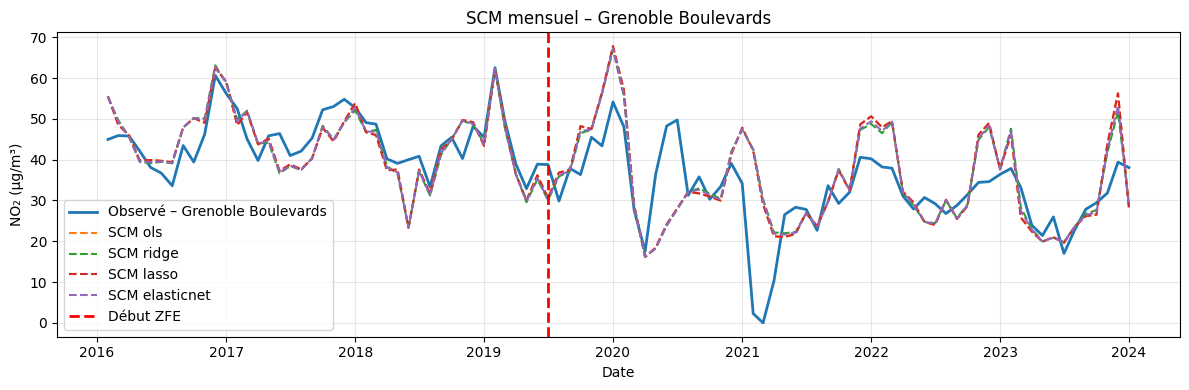


Poids des donneurs - SCM mensuel - méthode Ols


,station_id,station_name,station_env,station_influence,poids
7,FR36002,Valence Urb. Centre,Urbaine,Fond,1.588996
5,FR33111,SAINT JEAN,Urbaine,Fond,0.817279
6,FR33203,ANNECY Rocade,Urbaine,Trafic,0.731100
0,FR15018,Voiron Urbain,Urbaine,Fond,0.586867
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic,0.241939
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond,-0.065617
8,FR36019,Romans-sur-Isère,Urbaine,Fond,-0.598832
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond,-0.926671
4,FR33102,CHAMBERY LE HAUT,Urbaine,Fond,-1.226782



Poids des donneurs - SCM mensuel - méthode Ridge


,station_id,station_name,station_env,station_influence,poids
7,FR36002,Valence Urb. Centre,Urbaine,Fond,1.400121
6,FR33203,ANNECY Rocade,Urbaine,Trafic,0.700016
5,FR33111,SAINT JEAN,Urbaine,Fond,0.532325
0,FR15018,Voiron Urbain,Urbaine,Fond,0.526323
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic,0.315025
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond,-0.050592
8,FR36019,Romans-sur-Isère,Urbaine,Fond,-0.560798
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond,-0.660700
4,FR33102,CHAMBERY LE HAUT,Urbaine,Fond,-1.065883



Poids des donneurs - SCM mensuel - méthode Lasso


,station_id,station_name,station_env,station_influence,poids
7,FR36002,Valence Urb. Centre,Urbaine,Fond,1.588740
5,FR33111,SAINT JEAN,Urbaine,Fond,0.816544
6,FR33203,ANNECY Rocade,Urbaine,Trafic,0.731017
0,FR15018,Voiron Urbain,Urbaine,Fond,0.586659
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic,0.241978
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond,-0.065146
8,FR36019,Romans-sur-Isère,Urbaine,Fond,-0.598727
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond,-0.926172
4,FR33102,CHAMBERY LE HAUT,Urbaine,Fond,-1.226471



Poids des donneurs - SCM mensuel - méthode Elasticnet


,station_id,station_name,station_env,station_influence,poids
7,FR36002,Valence Urb. Centre,Urbaine,Fond,1.474337
6,FR33203,ANNECY Rocade,Urbaine,Trafic,0.709310
5,FR33111,SAINT JEAN,Urbaine,Fond,0.617688
0,FR15018,Voiron Urbain,Urbaine,Fond,0.543556
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic,0.281191
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond,-0.028392
8,FR36019,Romans-sur-Isère,Urbaine,Fond,-0.572702
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond,-0.749500
4,FR33102,CHAMBERY LE HAUT,Urbaine,Fond,-1.124126


In [95]:
# SCM mensuel – Grenoble Boulevards 

import pandas as pd
import matplotlib.pyplot as plt

# 1) Charger les données journalières imputées (cible + donneurs)
grenoble_target = pd.read_csv(
    DATA_DIR / "pollution_grenoble_no2_daily_imputed.csv",
    parse_dates=["date"],
)

donors_grenoble = pd.read_csv(
    DATA_DIR / "no2_donors_grenoble_daily_imputed.csv",
    parse_dates=["date"],
)


# Paramètres SCM
treated_id_gre = "FR15046"                  # Grenoble Boulevards
zfe_start_gre = pd.Timestamp("2019-07-01")  # début de la ZFE Grenoble (au mois près)

# Ajustement SCM mensuel (OLS, Ridge, Lasso, ElasticNet)
dates_m_gre, y_m_gre, synth_m_gre, w_m_gre = fit_penalized_scm_monthly(
    treated_daily=grenoble_target,
    donors_daily=donors_grenoble,
    treated_id=treated_id_gre,
    treatment_start=zfe_start_gre,
)

# Résumé des ATT mensuels (pré / post / post hors Covid)
att_m_gre = compute_att_summary(
    dates=dates_m_gre,
    y_treated=y_m_gre,
    synthetic_dict=synth_m_gre,
    treatment_start=zfe_start_gre,
    covid_start=pd.Timestamp("2020-03-01"),
    covid_end=pd.Timestamp("2021-06-30"),
)

print("ATT (µg/m³) – SCM mensuel – Grenoble Boulevards :")
display(att_m_gre)

# Graphique SCM mensuel
plt.figure(figsize=(12, 4))
plt.plot(dates_m_gre, y_m_gre, label="Observé – Grenoble Boulevards", linewidth=2)

for method, y_syn in synth_m_gre.items():
    plt.plot(y_syn.index, y_syn.values, "--", label=f"SCM {method}")

plt.axvline(zfe_start_gre, color="red", linestyle="--", linewidth=2, label="Début ZFE")
plt.title("SCM mensuel – Grenoble Boulevards")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Tableau des poids des donneurs (mensuel) pour chaque méthode

weights_tables_m_gre = make_weights_tables(w_m_gre, donors_grenoble)

for method, df in weights_tables_m_gre.items():
    print(f"\nPoids des donneurs - SCM mensuel - méthode {method.capitalize()}")
    display(df)



Avant la mise en place de la ZFE (jusqu’à mi-2019), les séries synthétiques mensuelles (OLS, Ridge, Lasso, ElasticNet) suivent très bien la trajectoire de **Grenoble Boulevards**. Les ATT moyens pré-traitement sont légèrement positifs (environ +0,5–0,6 µg/m³), ce qui signifie que la station réelle est, en moyenne, très légèrement au-dessus de son contrôle synthétique mais que l’écart reste faible. C’est exactement ce que l’on attend d’un bon SCM : un contrefactuel qui colle au mieux à l’unité traitée avant l’intervention.

Les tableaux de poids donnent un éclairage utile sur la composition du contrôle synthétique :

- **Valence Urbain Centre (FR36002)** apparaît comme donneur principal, avec un poids supérieur à 1 dans tous les modèles. Son profil urbain de fond et son exposition au trafic régional sont cohérents avec ceux de Grenoble.
- **Chambéry le Haut (FR33102)** et **Gresivaudan Périurbain (FR15048)** portent des poids négatifs importants. Elles servent à ajuster le niveau de la combinaison lorsque ces stations présentent des concentrations systématiquement plus élevées que Boulevards.
- **Annecy Rocade (FR33203)**, **Saint-Jean (FR33111)**, **Voiron Urbain (FR15018)** et **Gap Jean-Jaurès (FR24038)** complètent le mélange avec des poids positifs modérés.
- **Grenoble PériurbSud (FR15045)** et **Romans-sur-Isère (FR36019)** reçoivent des poids proches de zéro dans les versions pénalisées, ce qui suggère qu’elles n’apportent pas d’information décisive une fois les autres donneurs pris en compte.

La structure des poids est remarquablement stable d’un modèle à l’autre : les versions pénalisées (Ridge, Lasso, ElasticNet) ne bouleversent pas la combinaison mais resserrent les coefficients les plus extrêmes. Cela plaide pour une certaine robustesse du contrefactuel.

Après juillet 2019, plusieurs éléments ressortent :

- La période **Covid 2020-2021** se traduit par un effondrement brutal des niveaux de NO₂, visible à la fois sur la station traitée, mais pas totalement sur les donneurs. Comme ce choc est national, nous regardons également sans ces mois dans le calcul de l’ATT « post sans Covid » afin voir l'effet de retirer cette période à la ZFE et exclure les baisses clairement liées aux confinements et aux restrictions de mobilité.
- Une fois cette fenêtre retirée, les **ATT moyens post-traitement** sont **négatifs** et se situent entre environ –2,3 et –3,1 µg/m³ selon la méthode. Rapporté à un niveau moyen de 35–40 µg/m³ avant la ZFE, cela correspond à une diminution de l’ordre de 6 à 9 % par rapport au contrefactuel.

Il serait excessif d’en conclure que la ZFE explique seule cette baisse. D’autres facteurs interviennent : renforcement progressif des normes Euro et renouvellement du parc automobile, développement des transports collectifs et des mobilités alternatives, éventuelle réorganisation du trafic, conditions météorologiques sur certaines années, etc. Néanmoins, le fait que Grenoble Boulevards passe durablement en dessous de son contrôle synthétique, alors que l’ajustement pré-ZFE est très bon, est cohérent avec l’hypothèse d’un **effet additionnel** de la ZFE sur les niveaux de NO₂.

### SCM daily – Grenoble Boulevards

ATT (µg/m³) – SCM daily – Grenoble Boulevards :


,méthode,ATT_moy_pre,ATT_moy_post,ATT_moy_post_sans_Covid
0,Ols,2.929129e-15,-8.047899,-7.318587
1,Ridge,3.020665e-15,-8.070807,-7.337718
2,Lasso,4.119088e-16,-8.203218,-7.508140
3,Elasticnet,1.464565e-15,-8.226602,-7.535699


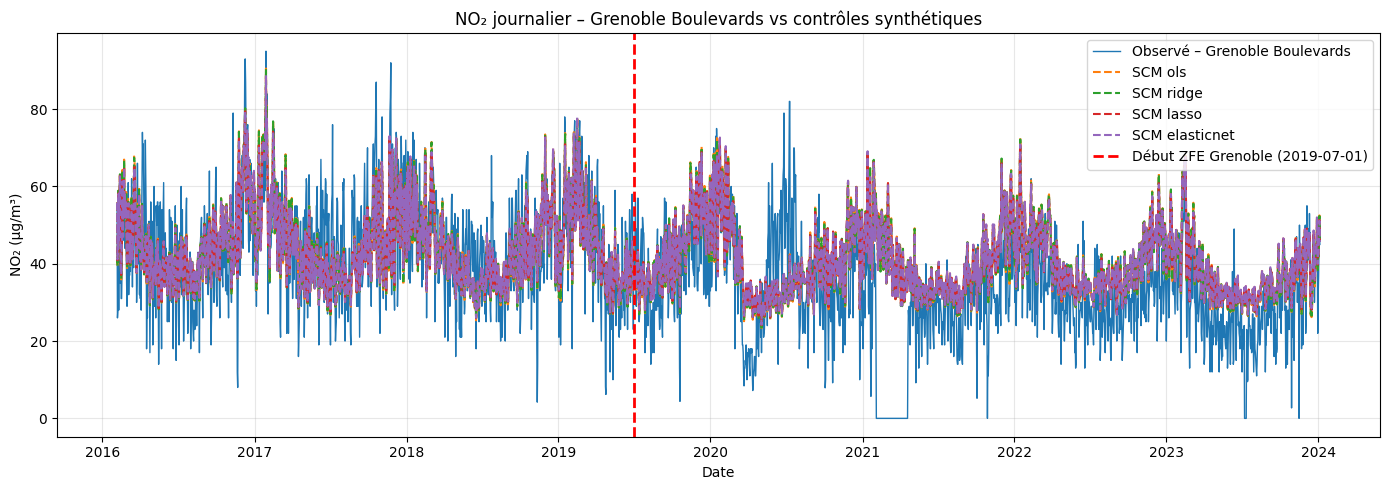

In [96]:
# === SCM daily – Grenoble Boulevards =========================================

# On réutilise grenoble_target et donors_grenoble chargés dans la cellule précédente.

# Ajustement SCM daily (OLS, Ridge, Lasso, ElasticNet)
dates_d_gre, y_d_gre, synth_d_gre, w_d_gre = fit_penalized_scm_daily(
    treated_daily=grenoble_target,
    donors_daily=donors_grenoble,
    treated_id=treated_id_gre,
    treatment_start=zfe_start_gre,
)

# Résumé des ATT journaliers (pré / post / post hors Covid)
att_d_gre = compute_att_summary(
    dates=dates_d_gre,
    y_treated=y_d_gre,
    synthetic_dict=synth_d_gre,
    treatment_start=zfe_start_gre,
    covid_start=pd.Timestamp("2020-03-01"),
    covid_end=pd.Timestamp("2021-06-30"),
)

print("ATT (µg/m³) – SCM daily – Grenoble Boulevards :")
display(att_d_gre)

# Graphique SCM daily
plt.figure(figsize=(14, 5))
plt.plot(dates_d_gre, y_d_gre, label="Observé – Grenoble Boulevards", linewidth=1)

for method, y_syn in synth_d_gre.items():
    plt.plot(y_syn.index, y_syn.values, "--", label=f"SCM {method}")

plt.axvline(zfe_start_gre, color="red", linestyle="--", linewidth=2,
            label="Début ZFE Grenoble (2019-07-01)")
plt.title("NO₂ journalier – Grenoble Boulevards vs contrôles synthétiques")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Pour tester la sensibilité des résultats à l’agrégation temporelle, on applique ensuite exactement la même démarche au **pas journalier**, en utilisant les séries imputées jour par jour pour la station traitée et pour les donneurs.

À cette échelle, on voit beaucoup mieux la structure fine de la pollution : alternance saisonnière hiver/été, épisodes aigus en hiver et lors de conditions anticycloniques stables, creux estivaux, etc. Les trajectoires synthétiques restent néanmoins très proches de la série observée, y compris jour par jour puisque : 

- en **pré-traitement**, les ATT moyens sont quasiment nuls (les valeurs sont de l’ordre de 10⁻¹⁵ en µg/m³, c’est-à-dire zéro à la précision numérique près), ce qui confirme la qualité du contrôle synthétique ;
- en **post-traitement**, les ATT journaliers tournent autour de –8 µg/m³, et entre environ –7,3 et –7,5 µg/m³ si fois la période Covid exclue.

Compte tenu d’un niveau moyen de NO₂ à Boulevards autour de 35–40 µg/m³, cela correspond à une baisse d’environ 15 à 20 % par rapport au contrefactuel quotidien. Le signal est donc plus marqué qu’en mensuel. En effet, l’agrégation au mois tend à lisser les épisodes où la station traitée diverge nettement de ses donneurs, ce qui réduit mécaniquement l’ATT moyen.

Au final, les SCM mensuel et daily racontent la même histoire. Le contrôle synthétique reproduit très bien la station traitée avant l’introduction de la ZFE. Après 2019, **Grenoble Boulevards** se situe en moyenne en dessous de son contrôle synthétique, avec une baisse modérée mais nette au pas mensuel (≈ 6–9 %) et une baisse plus marquée au pas journalier (≈ 15–20 %).

Les résultats sont stables entre OLS, Ridge, Lasso et ElasticNet et robustes au retrait de la période Covid. Ils ne démontrent pas que la ZFE est l’unique cause de la baisse du NO₂, mais ils sont compatibles avec l’idée que la ZFE contribue à accélérer la diminution des concentrations sur cette station de trafic. Dans la suite du rapport, on applique la même démarche à la station parisienne des **Champs-Élysées**, ce qui permettra de comparer les ordres de grandeur obtenus entre une agglomération de taille moyenne (Grenoble) et une métropole beaucoup plus dense (Paris).

### Résultats pour Paris – station Champs-Élysées
<a id="scm-Paris"></a> 

Pour Paris, nous nous concentrons sur la station « Av Champs-Élysées » (FR04031), située en plein cœur de la ZFE parisienne. Comme pour Grenoble, nous ne présentons dans le rapport détaillé que cette station. Les résultats obtenus pour l’autre station cible (Les Halles) sont du même ordre de grandeur.

Pour rappel, le contrôle synthétique est construit à partir de grandes agglomérations françaises sans ZFE active sur la période considérée.

#### SCM mensuel

Station traitée (Paris) : FR04031 – Champs-Élysées
Début ZFE Paris : 2021-06-01
Résumé des ATT (µg/m³) – Paris Champs-Élysées – SCM mensuel :


,méthode,ATT_moy_pre,ATT_moy_post,ATT_moy_post_sans_Covid
0,Ols,-0.116732,-0.649692,-0.575402
1,Ridge,-0.238565,-2.165638,-2.109415
2,Lasso,-0.261501,-1.479097,-1.404903
3,Elasticnet,-0.242143,-1.631527,-1.563134


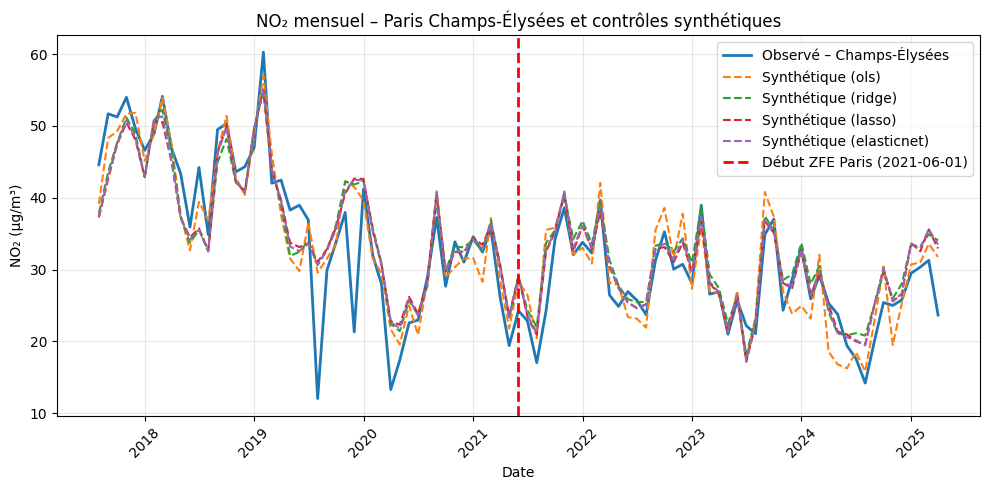

In [97]:
# Fichiers journaliers imputés (cibles + donneurs)
paris_targets = pd.read_csv(DATA_DIR / "pollution_paris_no2_daily_imputed.csv")
donors_paris = pd.read_csv(DATA_DIR / "no2_donors_paris_daily_imputed.csv")

# Station traitée = Champs-Élysées
treated_id_paris = "FR04031"
paris_start = pd.Timestamp("2021-06-01")  # début ZFE Paris (date utilisée pour le SCM)

print("Station traitée (Paris) :", treated_id_paris, "– Champs-Élysées")
print("Début ZFE Paris :", paris_start.date())

# SCM mensuel – Paris Champs-Élysées 

# Ajustement du SCM mensuel (OLS + pénalisés)
dates_paris_m, y_paris_m, synth_paris_m, weights_paris_m = fit_penalized_scm_monthly(
    treated_daily=paris_targets,
    donors_daily=donors_paris,
    treated_id=treated_id_paris,
    treatment_start=paris_start,
)

# ATT mensuels (pré / post / post hors Covid)
att_paris_m = compute_att_summary(
    dates=dates_paris_m,
    y_treated=y_paris_m,
    synthetic_dict=synth_paris_m,
    treatment_start=paris_start,
    covid_start=pd.Timestamp("2020-03-01"),
    covid_end=pd.Timestamp("2021-06-30"),
)

print("Résumé des ATT (µg/m³) – Paris Champs-Élysées – SCM mensuel :")
display(att_paris_m)

# Graphique mensuel
plt.figure(figsize=(10, 5))

plt.plot(dates_paris_m, y_paris_m, label="Observé – Champs-Élysées", linewidth=2)

for key, y_syn in synth_paris_m.items():
    label = f"Synthétique ({key})"
    ls = "--"
    plt.plot(dates_paris_m, y_syn, linestyle=ls, label=label)

plt.axvline(paris_start, color="red", linestyle="--", linewidth=2,
            label=f"Début ZFE Paris ({paris_start.date()})")

plt.title("NO₂ mensuel – Paris Champs-Élysées et contrôles synthétiques")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [98]:
weights_tables_m_par = make_weights_tables(weights_paris_m, donors_paris)

for method, df in weights_tables_m_par.items():
    print(f"\nPoids des donneurs - SCM mensuel - méthode {method.capitalize()}")
    display(df)


Poids des donneurs - SCM mensuel - méthode Ols


,station_id,station_name,station_env,station_influence,poids
0,FR01011,Metz-Centre,Urbaine,Fond,0.684239
7,FR23120,BEAUX ARTS,Urbaine,Fond,0.530003
10,FR26014,Dijon Trémouille,Urbaine,Fond,0.352015
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,0.335118
5,FR19007,HALLES,Urbaine,Trafic,0.171655
9,FR23188,CIM BOUTEILLERIE,Urbaine,Fond,0.070780
1,FR03068,TOULON FOCH,Urbaine,Trafic,-0.040867
11,FR30034,Nancy-Charles III,Urbaine,Fond,-0.053323
6,FR21001,Caen Chemin-Vert,Urbaine,Fond,-0.105810
12,FR31001,GRAND PARC,Urbaine,Fond,-0.113698



Poids des donneurs - SCM mensuel - méthode Ridge


,station_id,station_name,station_env,station_influence,poids
0,FR01011,Metz-Centre,Urbaine,Fond,0.226946
5,FR19007,HALLES,Urbaine,Trafic,0.180808
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,0.166830
10,FR26014,Dijon Trémouille,Urbaine,Fond,0.130620
11,FR30034,Nancy-Charles III,Urbaine,Fond,0.098370
7,FR23120,BEAUX ARTS,Urbaine,Fond,0.073547
1,FR03068,TOULON FOCH,Urbaine,Trafic,0.057258
9,FR23188,CIM BOUTEILLERIE,Urbaine,Fond,0.016781
3,FR08616,Nimes Planas,Urbaine,Trafic,0.012480
6,FR21001,Caen Chemin-Vert,Urbaine,Fond,-0.001135



Poids des donneurs - SCM mensuel - méthode Lasso


,station_id,station_name,station_env,station_influence,poids
0,FR01011,Metz-Centre,Urbaine,Fond,0.303321
5,FR19007,HALLES,Urbaine,Trafic,0.211371
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,0.192353
10,FR26014,Dijon Trémouille,Urbaine,Fond,0.044087
11,FR30034,Nancy-Charles III,Urbaine,Fond,0.029113
4,FR16069,Mulhouse-Briand,Urbaine,Trafic,-0.000000
3,FR08616,Nimes Planas,Urbaine,Trafic,0.000000
1,FR03068,TOULON FOCH,Urbaine,Trafic,0.000000
6,FR21001,Caen Chemin-Vert,Urbaine,Fond,0.000000
8,FR23174,GUEDOU,Urbaine,Fond,-0.000000



Poids des donneurs - SCM mensuel - méthode Elasticnet


,station_id,station_name,station_env,station_influence,poids
0,FR01011,Metz-Centre,Urbaine,Fond,0.312782
5,FR19007,HALLES,Urbaine,Trafic,0.212734
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,0.186875
10,FR26014,Dijon Trémouille,Urbaine,Fond,0.087524
11,FR30034,Nancy-Charles III,Urbaine,Fond,0.041035
8,FR23174,GUEDOU,Urbaine,Fond,-0.000000
3,FR08616,Nimes Planas,Urbaine,Trafic,0.000000
1,FR03068,TOULON FOCH,Urbaine,Trafic,0.000000
6,FR21001,Caen Chemin-Vert,Urbaine,Fond,-0.000000
9,FR23188,CIM BOUTEILLERIE,Urbaine,Fond,0.000000


Sur le graphique mensuel, les différentes séries synthétiques reproduisent bien la dynamique pré-traitement de Champs-Élysées : les pics hivernaux, la chute brutale de 2020 pendant les confinements, puis la remontée partielle de 2020-2021 sont correctement capturés. Les **ATT moyens en pré-traitement** sont proches de zéro (\(-0,12\) à \(-0,26\) µg/m³ selon les modèles), ce qui indique que \(Y_t^{(T)}\) et \(Y_t^{(\text{synth})}\) sont en moyenne indiscernables avant juin 2021, ce qui bien, pour rappel, une condition minimale pour interpréter ensuite les écarts comme un effet de la ZFE.

Après le début de la ZFE (juin 2021, ramené au début du mois), Champs-Élysées reste en moyenne **en dessous** de son contrôle synthétique. Les **ATT mensuels post-traitement** sont compris entre environ  
\(-0,65\) µg/m³ (OLS) et \(-2,2\) µg/m³ (Ridge), Lasso et ElasticNet donnant des valeurs intermédiaires autour de \(-1,5\) à \(-1,6\) µg/m³. Rapporté à un niveau moyen d’environ 25–30 µg/m³ sur la période récente, cela correspond à une baisse de l’ordre de **3 à 8 %** par rapport au contrefactuel, selon le modèle retenu.

Aussi, les principaux donneurs qui reçoivent un poids non négligeable sont : **Metz-Centre (FR01011)**, **Le Havre Lafaurie-Montant (FR05089)**, **Rennes – Les Halles (FR19007)**,  **Dijon Trémouille (FR26014)**, **Nancy Charles-III (FR30034)** et, dans une moindre mesure, **Angers – Beaux-Arts**, **Nantes – Cim Bouteillerie**, **Bordeaux – Grand Parc**, **Le Mans – Guédou**.

En régression **OLS mensuelle**, les poids sont assez dispersés et certains deviennent négatifs (par exemple Le Mans – Guédou), ce qui reflète un ajustement très flexible mais potentiellement instable. Les versions pénalisées (Ridge, Lasso, ElasticNet) « resserrent » la combinaison puisque les poids se concentrent surtout sur Metz, Le Havre, Rennes et Dijon/Nancy, et la pénalisation contraint les autres donneurs vers des contributions faibles ou nulles (Lasso met à zéro la plupart des stations secondaires).

Concernant la **Covid-19**, la quasi-totalité des épisodes de confinements et de couvre-feux (mars–mai 2020, automne 2020, début 2021) se situe **avant** l’introduction de la ZFE. De nombreux travaux, notamment ceux d’Airparif, documentent des baisses de NO₂ de 30 à 60 % pendant le premier confinement à Paris, principalement liées à l’effondrement du trafic routier.
Dans notre dispositif, ces épisodes sont utilisés pour **calibrer** le contrôle synthétique puisque ici les donneurs sont forcés à reproduire non seulement la tendance de fond mais aussi le choc Covid (d'où l'intérêt aussi de la méthode du contrôle synthétique ici car cette crise a touché toute la France et est modélisé dans notre estimation avant traitement). Aussi, et c'est logique, lorsque l’on exclut explicitement les mois « Covid » du calcul (ATT\_moy\_post\_sans\_Covid), les résultats changent très peu car seule la période de transition du printemps 2021 est affectée.

Ces résultats de baisse en lien avec la ZFE restent néanmoins à interpréter avec prudence. Paris a mis en œuvre **d’autres politiques de mobilité** au même moment : généralisation du 30 km/h à partir de l’été 2021, piétonnisation et ZTL dans l’hyper-centre, développement massif des pistes cyclables (« coronapistes » puis pérennisation), hausse du coût du stationnement et restrictions croissantes sur les véhicules diesel.  

Le contrôle synthétique corrige en principe pour les tendances nationales (renouvellement du parc, normes Euro successives, diffusion du télétravail) via les donneurs, mais il ne permet pas de distinguer finement ce qui relève **spécifiquement** de la ZFE de ce qui tient à ces autres mesures locales. L’ATT mesure donc plutôt ici un **effet global des politiques de restriction du trafic dans Paris intramuros** que l’impact isolé de la seule ZFE.

#### SCM Daily

Effets moyens du traitement (ATT) – SCM daily – Paris Champs-Élysées


,méthode,ATT_moy_pre,ATT_moy_post,ATT_moy_post_sans_Covid
0,Ols,-4.283852e-15,-2.394373,-2.402133
1,Ridge,-2.636217e-15,-2.396069,-2.403833
2,Lasso,-5.931487e-15,-2.469786,-2.476758
3,Elasticnet,-2.306689e-15,-2.454089,-2.461463


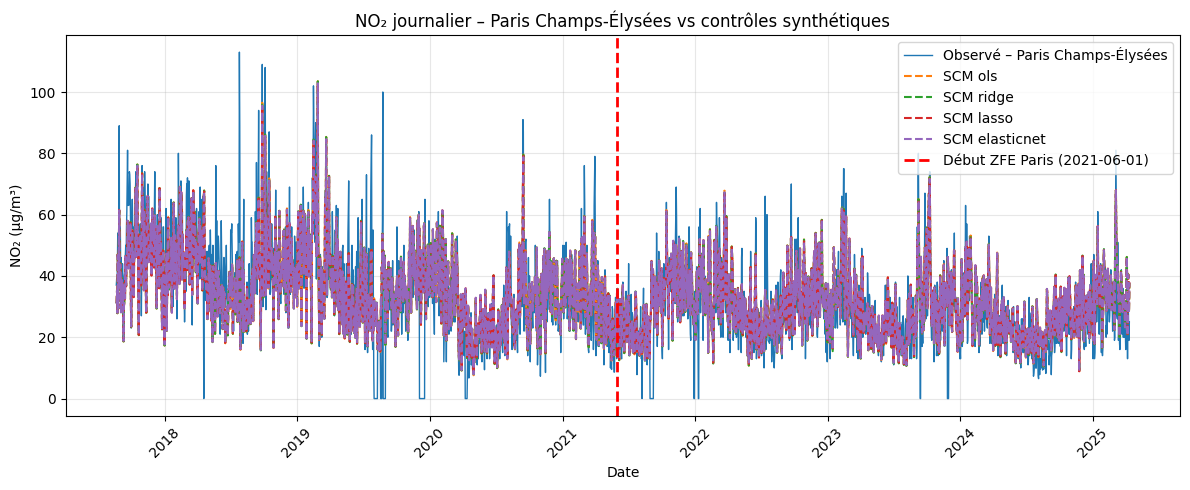

In [99]:
# SCM daily – Paris Champs-Élysées

dates_paris_d, y_paris_d, synth_paris_d, weights_paris_d = fit_penalized_scm_daily(
    treated_daily=paris_targets,
    donors_daily=donors_paris,
    treated_id=treated_id_paris,
    treatment_start=paris_start,
)

att_paris_d = compute_att_summary(
    dates=dates_paris_d,
    y_treated=y_paris_d,
    synthetic_dict=synth_paris_d,
    treatment_start=paris_start,
    covid_start=pd.Timestamp("2020-03-01"),
    covid_end=pd.Timestamp("2021-06-30"),
)

print("Effets moyens du traitement (ATT) – SCM daily – Paris Champs-Élysées")
display(att_paris_d)

# Graphique daily
plt.figure(figsize=(12, 5))

plt.plot(dates_paris_d, y_paris_d, label="Observé – Paris Champs-Élysées", linewidth=1)

for key, y_syn in synth_paris_d.items():
    label = f"SCM {key}"
    plt.plot(dates_paris_d, y_syn, linestyle="--", label=label)

plt.axvline(paris_start, color="red", linestyle="--", linewidth=2,
            label=f"Début ZFE Paris ({paris_start.date()})")

plt.title("NO₂ journalier – Paris Champs-Élysées vs contrôles synthétiques")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [100]:
weights_tables_d_par = make_weights_tables(weights_paris_d, donors_paris)

for method, df in weights_tables_d_par.items():
    print(f"\nPoids des donneurs – SCM daily – méthode {method.capitalize()}")
    display(df)


Poids des donneurs – SCM daily – méthode Ols


,station_id,station_name,station_env,station_influence,poids
0,FR01011,Metz-Centre,Urbaine,Fond,0.148112
11,FR30034,Nancy-Charles III,Urbaine,Fond,0.123073
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,0.120558
10,FR26014,Dijon Trémouille,Urbaine,Fond,0.105345
5,FR19007,HALLES,Urbaine,Trafic,0.096377
8,FR23174,GUEDOU,Urbaine,Fond,0.085081
7,FR23120,BEAUX ARTS,Urbaine,Fond,0.055905
3,FR08616,Nimes Planas,Urbaine,Trafic,0.051149
4,FR16069,Mulhouse-Briand,Urbaine,Trafic,0.022938
12,FR31001,GRAND PARC,Urbaine,Fond,0.022370



Poids des donneurs – SCM daily – méthode Ridge


,station_id,station_name,station_env,station_influence,poids
0,FR01011,Metz-Centre,Urbaine,Fond,0.147729
11,FR30034,Nancy-Charles III,Urbaine,Fond,0.122965
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,0.120397
10,FR26014,Dijon Trémouille,Urbaine,Fond,0.105107
5,FR19007,HALLES,Urbaine,Trafic,0.096286
8,FR23174,GUEDOU,Urbaine,Fond,0.084497
7,FR23120,BEAUX ARTS,Urbaine,Fond,0.055884
3,FR08616,Nimes Planas,Urbaine,Trafic,0.051093
4,FR16069,Mulhouse-Briand,Urbaine,Trafic,0.023189
12,FR31001,GRAND PARC,Urbaine,Fond,0.022424



Poids des donneurs – SCM daily – méthode Lasso


,station_id,station_name,station_env,station_influence,poids
0,FR01011,Metz-Centre,Urbaine,Fond,0.145177
11,FR30034,Nancy-Charles III,Urbaine,Fond,0.121260
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,0.119008
10,FR26014,Dijon Trémouille,Urbaine,Fond,0.104864
5,FR19007,HALLES,Urbaine,Trafic,0.095444
8,FR23174,GUEDOU,Urbaine,Fond,0.074543
7,FR23120,BEAUX ARTS,Urbaine,Fond,0.054144
3,FR08616,Nimes Planas,Urbaine,Trafic,0.049885
4,FR16069,Mulhouse-Briand,Urbaine,Trafic,0.024517
12,FR31001,GRAND PARC,Urbaine,Fond,0.020260



Poids des donneurs – SCM daily – méthode Elasticnet


,station_id,station_name,station_env,station_influence,poids
0,FR01011,Metz-Centre,Urbaine,Fond,0.142226
11,FR30034,Nancy-Charles III,Urbaine,Fond,0.120703
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,0.118006
10,FR26014,Dijon Trémouille,Urbaine,Fond,0.102252
5,FR19007,HALLES,Urbaine,Trafic,0.094832
8,FR23174,GUEDOU,Urbaine,Fond,0.074194
7,FR23120,BEAUX ARTS,Urbaine,Fond,0.054663
3,FR08616,Nimes Planas,Urbaine,Trafic,0.049886
4,FR16069,Mulhouse-Briand,Urbaine,Trafic,0.026603
12,FR31001,GRAND PARC,Urbaine,Fond,0.021993


Le SCM journalier applique exactement la même logique sur les séries quotidiennes, beaucoup plus bruitées. Les contrôles synthétiques (OLS, Ridge, Lasso, ElasticNet) épousent bien la saisonnalité et les variations lentes de Champs-Élysées, tout en lissant les pics individuels (jours de pollution ou épisodes météorologiques particuliers).

Sur la période pré-ZFE, les **ATT journaliers moyens** sont numériquement nuls (de l’ordre de \(10^{-15}\) µg/m³), ce qui confirme la bonne qualité de l’appariement avant traitement. Après juin 2021, les quatre méthodes donnent des **ATT journaliers post-traitement très proches**, autour de \(-2,4\) µg/m³, avec des valeurs quasiment identiques lorsque l’on exclut les derniers jours encore marqués par des restrictions liées au Covid. La convergence des quatre modèles (ici en termes de donneurs également, où l'OLS se rapproche fortement des autres méthodes) suggère que le résultat est **robuste au choix de la pénalisation**. Ainsi, que l’on autorise ou non une forte complexité dans la combinaison des donneurs, on obtient le même ordre de grandeur pour l’écart moyen entre la station traitée et son contrefactuel.

Notons que les deux approches racontent la même histoire : une baisse modérée mais persistante des concentrations de NO₂ aux Champs-Élysées par rapport à ce que l’on aurait attendu à partir de l’évolution simultanée des grandes villes françaises non soumises aux mêmes restrictions.

#### Conclusion sur Paris

En résumé, le contrôle synthétique met en évidence, pour la station Champs-Élysées :

- **une très bonne adhérence pré-ZFE** entre la série observée et le contrefactuel, y compris pendant les chocs Covid ;
- **un écart négatif systématique après 2021**, de l’ordre de 1 à 2 µg/m³ en mensuel et d’environ 2,4 µg/m³ en journalier ;
- **des résultats stables** entre OLS, Ridge, Lasso et ElasticNet, surtout en journalier.

Ces éléments sont cohérents avec l’idée d’un **effet global des politiques parisiennes de restriction du trafic (dont la ZFE fait partie)** sur les niveaux de NO₂ en hyper-centre. Ils restent toutefois à interpréter selon plusieurs limites : absence de test formel de significativité dans ce cadre, possible sensibilité au choix précis des donneurs, et difficulté à dissocier ZFE, généralisation du 30 km/h, nouveaux aménagements cyclables et autres mesures qui ont toutes contribué, selon Airparif, à la baisse d’environ 45 % du NO₂ à Paris en une décennie.

## 4. Modélisation par méthodes de machin-learning
<a id="ml"></a>


<a id="ml-spec"></a>
### Spécification et stratégie d’estimation

En complément du contrôle synthétique, nous avons testé une approche plus flexible
basée sur des méthodes de machine learning supervisé. L’idée reste la même, celle de construire, pour chaque station traitée, un **contrefactuel** de la trajectoire de NO₂,
mais cette fois en laissant le modèle apprendre des relations non linéaires entre
villes et des effets calendaires (saisonnalité, jour de la semaine). En effet, pour l’approche machine learning, nous avons décider d'utiliser les autres villes non pas comme séries à expliquer, mais comme covariables pour prédire la concentration de NO₂ sur la station traitée. Concrètement, les modèles sont entraînés sur le pré-traitement pour apprendre la relation entre le niveau de NO₂ aux Champs-Élysées (ou à Grenoble Boulevards) et le niveau de NO₂ observé simultanément dans un panel d’autres grandes villes françaises.

L’idée est que ces villes jouent le rôle de capteurs des chocs communs (météo, tendances nationales, effets Covid, etc.) : si un épisode anticyclonique ou une politique nationale fait baisser le NO₂ partout, cela sera enregistré dans les donneurs et absorbé par le modèle.

D'un point de vue technique, nous procédons comme suit pour chaque station (Grenoble Boulevards, Paris Champs-Élysées) :

1. nous partons des tables journalières **imputées** (section précédente),
   pour la station traitée et pour un ensemble d’autres stations françaises
   (le même panel que celui utilisé comme « donneurs » dans le SCM).
2. Puis, nous construisons un panel journalier où, à chaque date \(t\), la cible
   est la concentration de NO₂ de la station traitée \(Y_t^{(T)}\) et les
   variables explicatives sont :
   - les concentrations de NO₂ observées le même jour dans les autres villes,
   - des variables calendaires (mois, jour de la semaine) encodées de façon
     cyclique (sinus / cosinus) pour capturer la saisonnalité.
3. Ensuite, nous définissons la période **pré-traitement** comme l’ensemble des jours
   antérieurs à la date de mise en place de la ZFE (date extraite de `zfe_meta`).
   Les modèles de ML ne voient que cette période pour l’estimation.
4. Puis, nous ajustons ensuite, séparément pour chaque station traitée, plusieurs
   modèles de régression sur le pré-traitement et nous produisons une série
   contrefactuelle \( \hat Y_t^{(\text{ML})} \) sur toute la période (pré + post).
5. Enfin, nous calculons un indicateur analogue à l’ATT :
   \[
   ATT^{\text{ML}} = \frac{1}{N_{\text{post}}}\sum_{t \geq T_0}
   \big( Y_t^{(T)} - \hat Y_t^{(\text{ML})} \big),
   \]
   ainsi que sa version « post-sans-Covid », en excluant les jours compris
   dans la fenêtre de confinement (2020–2021).

Cette construction est très proche du SCM en termes d’interprétation. En effet, une valeur **négative** de \(ATT^{\text{ML}}\) signifie que, en moyenne sur la période post-ZFE, les concentrations observées sont **plus faibles** que ce que prédit le modèle entraîné sur le pré-traitement et cela va dans le sens d’un effet « bénéfique » de la ZFE sur le NO₂. Puis, une valeur **proche de zéro** suggère au contraire que l’on ne détecte pas de rupture nette par rapport à ce que la dynamique pré-ZFE et les autres villes laisseraient prévoir.

### Choix des modèles et des hyperparamètres

Nous avons retenu deux familles de modèles de régression, implémentées dans
le module `scripts/ml_models.py` via la fonction générique
`fit_ml_counterfactual_daily` :

- une **forêt aléatoire de régression** (`RandomForestRegressor`) ;
- un **gradient boosting** de type LightGBM (`LGBMRegressor`).

Ces modèles présentent plusieurs intérêts dans notre contexte. Déjà, ils gèrent naturellement des relations **non linéaires** et des interactions complexes entre villes (par exemple : l’impact d’une baisse à Rennes ou Metz sur la trajectoire parisienne peut dépendre de la saison). Ensuite, ils sont relativement robustes au bruit, ce qui est utile sur des données journalières de pollution très volatiles d’un jour à l’autre. Enfin, ils restent interprétables a minima via l’importance des variables (importance des différentes villes dans la prédiction).

Les hyperparamètres sont fixés pour refléter un compromis simple
entre flexibilité et robustesse :

- Pour la **forêt aléatoire** :
  - `n_estimators = 500` : suffisamment d’arbres pour stabiliser la prédiction,
    sans exploser les temps de calcul sur ~8–9 ans de données journalières ;
  - `min_samples_leaf = 10` : on impose qu’une règle de décision soit estimée
    sur au moins 10 jours, ce qui évite de sur-apprendre quelques valeurs
    aberrantes isolées ;
  - `max_depth = None` mais avec cette contrainte sur la taille des feuilles,
    ce qui laisse au modèle la possibilité de capter des effets complexes tout
    en contrôlant la variance.

- Pour **LightGBM** :
  - `n_estimators = 500` et `learning_rate = 0.05` : schéma de boosting où l’on
    additionne beaucoup de petits arbres, ce qui permet d’améliorer la précision
    progressivement plutôt que de tout jouer sur quelques arbres très profonds ;
  - `num_leaves = 31` : taille modérée des arbres, pour éviter des règles trop
    fines sur quelques jours seulement ;
  - `subsample = 0.8` et `colsample_bytree = 0.8` : on introduit un
    sous-échantillonnage en lignes et en colonnes pour réduire la variance et
    améliorer la capacité de généralisation hors échantillon.

Nous n’avons volontairement pas cherché les hyperparamètres « optimaux » via
une recherche exhaustive (grid search) ou du **Optuna**. L’objectif est de disposer de modèles suffisamment riches pour fournir un contrefactuel alternatif raisonnable, tout en gardant une configuration reproductible, lisible, et raisonnable en temps de calcul.

### Résultats pour Grenoble
<a id="ml-grenoble"></a>

Pour la station **Grenoble Boulevards**, les modèles de ML sont ajustés au pas **journalier** sur la période pré-ZFE (jusqu’en juin 2019), en utilisant, comme dit précédemment, comme covariables les concentrations de NO₂ dans les autres villes françaises et quelques variables calendaires.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 1242, number of used features: 15
[LightGBM] [Info] Start training from score 44.848309
ATT – ML (Grenoble Boulevards) :


,méthode,ATT_moy_pre,ATT_moy_post,ATT_moy_post_sans_Covid
0,Rf,-1.747706e-02,-7.087436,-6.596060
1,Lgbm,4.317929e-10,-6.721998,-6.227293


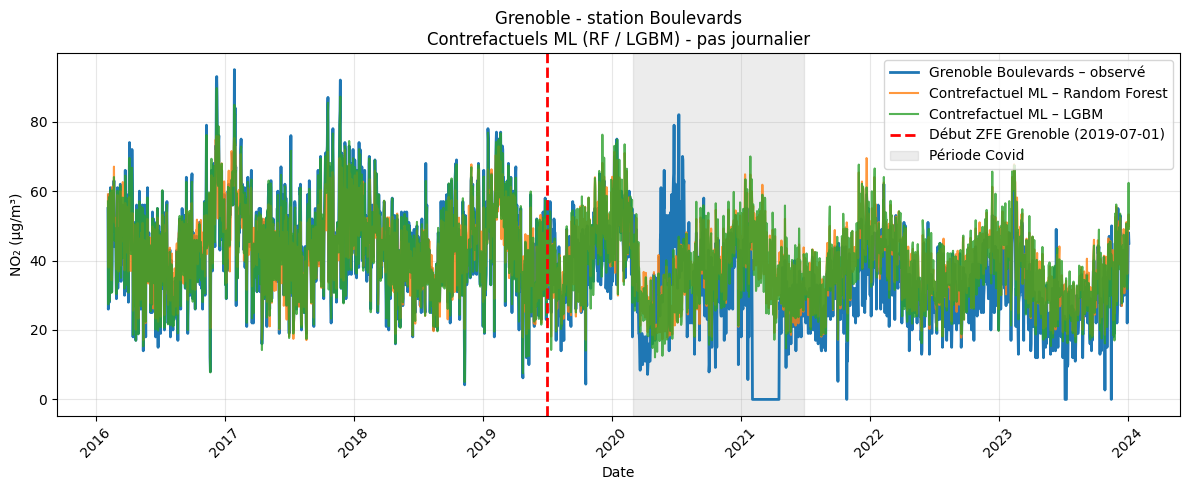

In [101]:
# ML pour prédiction Grenoble

# Chargement des données
grenoble_target = pd.read_csv(DATA_DIR / "pollution_grenoble_no2_daily_imputed.csv")
donors_grenoble = pd.read_csv(DATA_DIR / "no2_donors_grenoble_daily_imputed.csv")

grenoble_target["date"] = pd.to_datetime(grenoble_target["date"])
donors_grenoble["date"] = pd.to_datetime(donors_grenoble["date"])

# Station traitée, ici Grenoble Boulevards
treated_id_gre = "FR15046"

# Date de début de la ZFE Grenoble (on reste cohérent avec la partie SCM)
treat_start_gre = pd.Timestamp("2019-07-01")

# Fenêtre Covid utilisée pour exclure les confinements dans l'ATT "post_sans_Covid"
covid_start = pd.Timestamp("2020-03-01")
covid_end   = pd.Timestamp("2021-06-30")

# Ajustement des modèles ML (RF + LGBM)

dates_gre_ml, y_gre_ml, synth_gre_ml, fitted_gre_ml = fit_ml_counterfactual_daily(
    treated_daily=grenoble_target,
    donors_daily=donors_grenoble,
    treated_id=treated_id_gre,
    treatment_start=treat_start_gre,
    random_state=0,  # reproductibilité
)

# Calcul des ATT (pré / post / post hors Covid)

att_gre_ml = compute_att_summary(
    dates=dates_gre_ml,
    y_treated=y_gre_ml,
    synthetic_dict=synth_gre_ml,
    treatment_start=treat_start_gre,
    covid_start=covid_start,
    covid_end=covid_end,
)

print("ATT – ML (Grenoble Boulevards) :")
display(att_gre_ml)


# Graphique : observé vs RF / LGBM

plt.figure(figsize=(12, 5))

plt.plot(dates_gre_ml, y_gre_ml, label="Grenoble Boulevards – observé", linewidth=2)
plt.plot(dates_gre_ml, synth_gre_ml["rf"],   label="Contrefactuel ML – Random Forest", alpha=0.8)
plt.plot(dates_gre_ml, synth_gre_ml["lgbm"], label="Contrefactuel ML – LGBM", alpha=0.8)

plt.axvline(treat_start_gre, color="red", linestyle="--", linewidth=2,
            label=f"Début ZFE Grenoble ({treat_start_gre.date()})")

# Zone grisée pour la période Covid
plt.axvspan(covid_start, covid_end, color="grey", alpha=0.15, label="Période Covid")

plt.title("Grenoble - station Boulevards\nContrefactuels ML (RF / LGBM) - pas journalier")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 1242, number of used features: 15
[LightGBM] [Info] Start training from score 44.848309
R² pré-traitement - Grenoble Boulevards
     RF : R² = 0.791
   LGBM : R² = 0.987


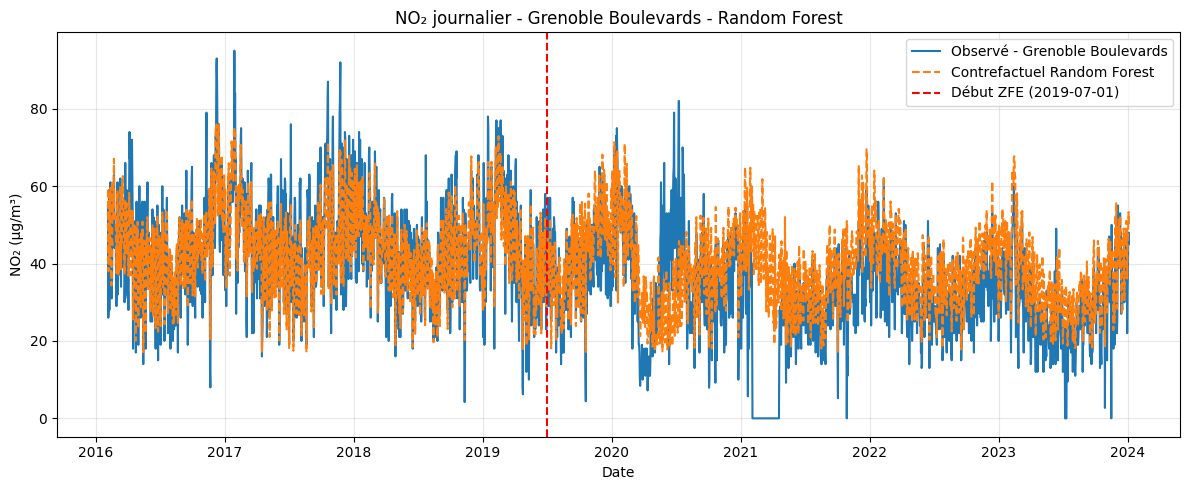

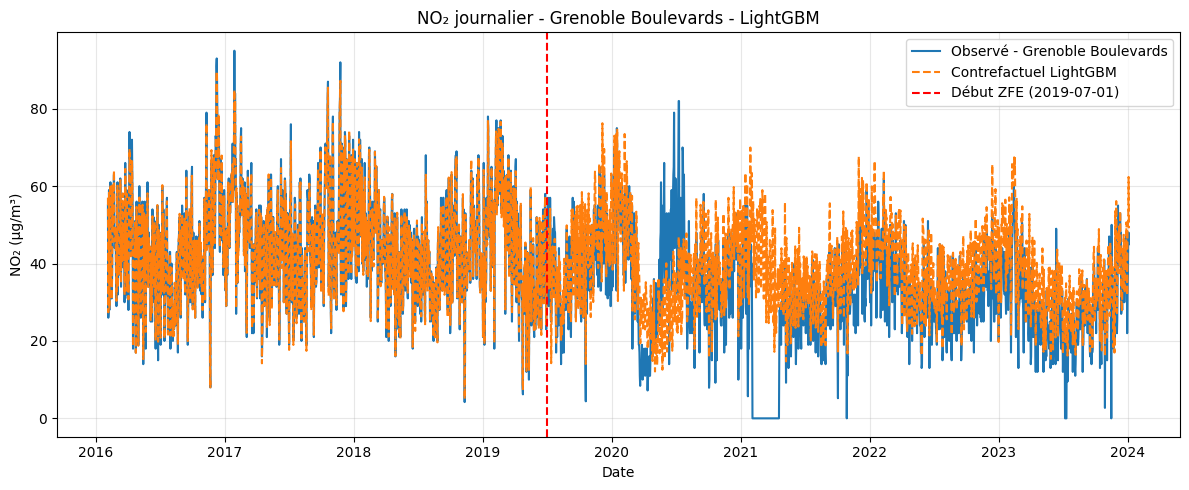

ATT - ML (Grenoble Boulevards) :


,méthode,ATT_moy_pre,ATT_moy_post,ATT_moy_post_sans_Covid
0,Rf,-1.747706e-02,-7.087436,-6.596060
1,Lgbm,4.317929e-10,-6.721998,-6.227293


In [102]:
# ML pour prédiction Grenoble

# Chargement des données
grenoble_target_ml = pd.read_csv(DATA_DIR / "pollution_grenoble_no2_daily_imputed.csv")
donors_grenoble_ml = pd.read_csv(DATA_DIR / "no2_donors_grenoble_daily_imputed.csv")

for df in (grenoble_target_ml, donors_grenoble_ml):
    df["date"] = pd.to_datetime(df["date"])

# Station traitée = Grenoble Boulevards
treated_id_gre = "FR15046"
zfe_start_gre = pd.Timestamp("2019-07-01")  # date de début ZFE Grenoble

#  Ajustement des modèles ML 
dates_gre_ml, y_gre_ml, synth_gre_ml, models_gre = fit_ml_counterfactual_daily(
    treated_daily=grenoble_target_ml,
    donors_daily=donors_grenoble_ml,
    treated_id=treated_id_gre,
    treatment_start=zfe_start_gre,
    random_state=0,
)

#  R² pré-traitement 
pre_mask_gre = dates_gre_ml < zfe_start_gre

print("R² pré-traitement - Grenoble Boulevards")
for name, y_hat in synth_gre_ml.items():
    r2_pre = r2_score(y_gre_ml[pre_mask_gre], y_hat[pre_mask_gre])
    print(f"  {name.upper():>5} : R² = {r2_pre:.3f}")

# Graphiques séparés RF / LGBM 
for name, title in [("rf", "Random Forest"), ("lgbm", "LightGBM")]:

    plt.figure(figsize=(12, 5))
    plt.plot(
        dates_gre_ml,
        y_gre_ml,
        label="Observé - Grenoble Boulevards",
        linewidth=1.5,
    )
    plt.plot(
        dates_gre_ml,
        synth_gre_ml[name],
        label=f"Contrefactuel {title}",
        linewidth=1.5,
        linestyle="--",
    )
    plt.axvline(
        zfe_start_gre,
        color="red",
        linestyle="--",
        label=f"Début ZFE ({zfe_start_gre.date()})",
    )
    plt.title(f"NO₂ journalier - Grenoble Boulevards - {title}")
    plt.xlabel("Date")
    plt.ylabel("NO₂ (µg/m³)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# Calcul des ATT (pré / post / post hors Covid)

att_gre_ml = compute_att_summary(
    dates=dates_gre_ml,
    y_treated=y_gre_ml,
    synthetic_dict=synth_gre_ml,
    treatment_start=treat_start_gre,
    covid_start=covid_start,
    covid_end=covid_end,
)

print("ATT - ML (Grenoble Boulevards) :")
display(att_gre_ml)


Tout d'abord, notons que la qualité d’ajustement en pré-traitement est très différente selon le modèle. Pour Random Forest, on a  \(R^2 \approx 0,79\) et LightGBM, on a \(R^2 \approx 0,99\).

La Random Forest capture déjà correctement la saisonnalité annuelle et l’ordre de grandeur des niveaux de NO₂, mais elle a tendance à lisser davantage les pics. Le modèle LightGBM, grâce au boosting et à une granularité plus fine des arbres, reproduit quasiment parfaitement la série journalière observée avant 2019. On voit qu'il réstitue parfaitement les effets saisonniers, les différences entre jours de semaine et week-end et les co-mouvements avec les autres villes. Cela confirme que les covariables choisies (autres stations + calendrier) contiennent suffisamment d’information pour reconstruire une trajectoire dite "business as usual" crédible.

Sur les graphiques, les deux contrefactuels restent ensuite dans un régime "normal" après l’introduction de la ZFE (juillet 2019). En particulier, **ils ne reproduisent pas la chute brutale de NO₂ pendant les confinements de 2020-2021**. Comme attendu pour des modèles purement prédictifs, entraînés uniquement sur des années passées, le choc exogène du Covid est hors domaine d’apprentissage et ne peut pas être anticipé (c'est le seul défaut des modèles prédictifs !). C’est précisément ce que l’on exploite ensuite dans le calcul d’ATT en retirant explicitement la fenêtre Covid des moyennes post-traitement.

De même, on rappel que les effets moyens du traitement (ATT) sont calculés comme la différence moyenne
\[
\text{ATT}_t = Y_t^{\text{observé}} - \hat Y_t^{\text{ML}}
\]
où \(\hat Y_t^{\text{ML}}\) est la prédiction du modèle entraîné uniquement sur la période pré-traitement.

Pour Grenoble Boulevards, on obtient :

- en **pré-traitement**, des ATT moyens quasi nuls pour les deux modèles (-0,02 µg/m³ pour la Random Forest, ~0 pour LightGBM), ce qui valide le calibrage du contrefactuel ;
- en **post-traitement**, des effets moyens très négatifs :
  - RF : \(-7,09\) µg/m³ sur toute la période post, \(-6,60\) µg/m³ en excluant la fenêtre Covid ;
  - LGBM : \(-6,72\) µg/m³ sur toute la période post, \(-6,23\) µg/m³ hors Covid.

L’écart entre "post" et "post sans Covid" illustre l’impact du confinement. En effet, pendant ces mois, la station observée passe très en dessous de la trajectoire "normale" prédite par le modèle, ce qui accentue encore l’ATT négatif. Une fois la fenêtre Covid retirée, il reste néanmoins une réduction moyenne d’environ 6 µg/m³ par rapport au scénario de référence, ce qui est cohérent avec l’ordre de grandeur trouvé avec le SCM daily et représente une baisse non négligeable compte tenu des niveaux pré-ZFE.

Ces résultats confortent l’idée que, toutes choses égales par ailleurs (structure de fond des autres villes, saisonnalité, tendance de long terme), les concentrations de NO₂ sur Grenoble Boulevards sont durablement plus faibles après 2019 qu’avant. Il faut toutefois rester prudent puisque la période post-ZFE est également marquée par d’autres évolutions non observées dans nos données (renouvellement du parc automobile, développement des transports en commun, généralisation des zones 30 à Grenoble depuis 2016, etc.), qui peuvent contribuer à la baisse du NO₂ en plus de la ZFE.

Enfin, contrairement au SCM, ces modèles demeurent en pratique des **"boîtes noires"**. Ils combinent de manière non linéaire des dizaines de variables issues des autres villes et du calendrier. L’ATT calculé ici ne doit donc pas être interprété comme un effet causal identifié de la ZFE, mais comme un **écart moyen entre la trajectoire observée et ce qu’un modèle prédictif flexible aurait attendu à partir du passé**. Le fait que cet écart soit robuste, d’un signe et d’un ordre de grandeur proches de ceux obtenus par SCM, renforce cependant la crédibilité d’un effet réel (au sens large) des politiques locales de réduction du trafic à Grenoble et parmi eux, de la ZFE

<a id="ml-paris"></a>
### Résultats pour Paris

Pour **Paris Champs-Élysées**, la même stratégie est appliquée : on ajuste les modèles au pas journalier sur la période pré-ZFE (jusqu’en mai 2021) et l’on prédit la trajectoire contrefactuelle après le 1ᵉʳ juin 2021.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3370
[LightGBM] [Info] Number of data points in the train set: 1380, number of used features: 19
[LightGBM] [Info] Start training from score 37.242246
R² pré-traitement - Paris Champs-Élysées
     RF : R² = 0.742
   LGBM : R² = 0.994


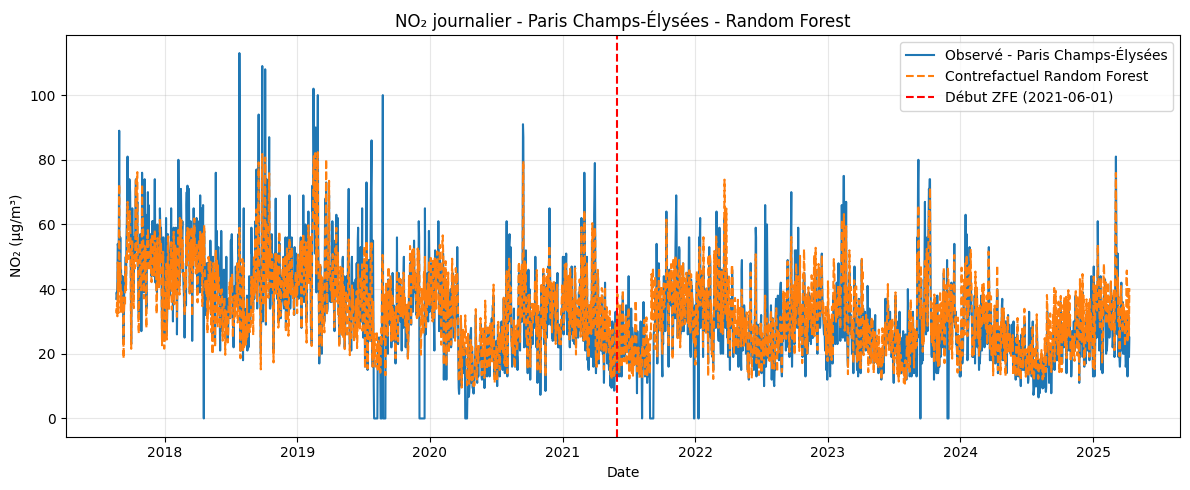

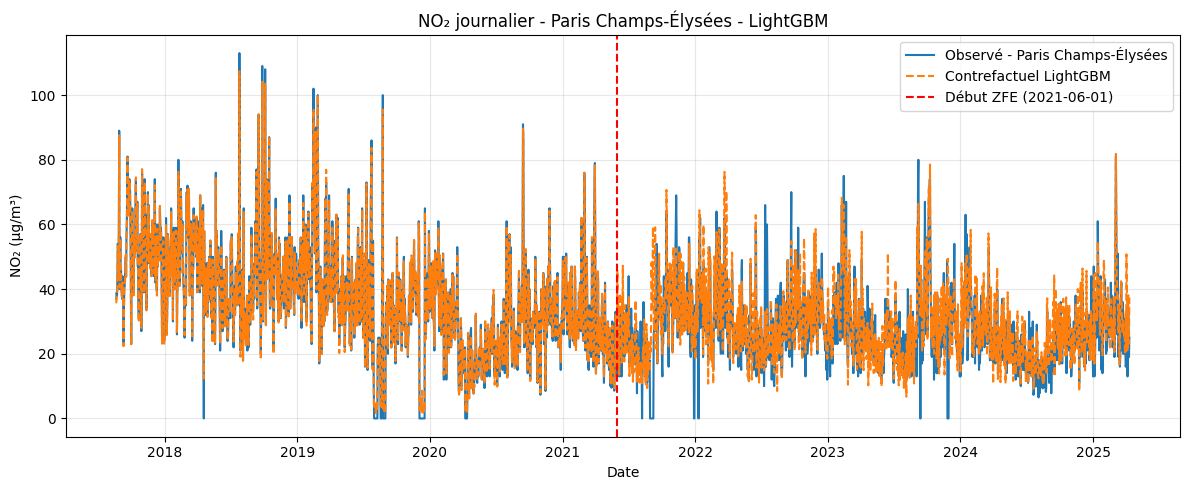

ATT - ML (Paris Champs-Élysées) :


,méthode,ATT_moy_pre,ATT_moy_post,ATT_moy_post_sans_Covid
0,Rf,1.065828e-02,-2.559696,-2.558691
1,Lgbm,4.958456e-12,-1.981307,-1.919372


In [103]:
# ML pour Paris Champs-Elysées

paris_target_ml = pd.read_csv(DATA_DIR / "pollution_paris_no2_daily_imputed.csv")
donors_paris_ml = pd.read_csv(DATA_DIR / "no2_donors_paris_daily_imputed.csv")

for df in (paris_target_ml, donors_paris_ml):
    df["date"] = pd.to_datetime(df["date"])

# Station traitée = Paris Champs-Élysées
treated_id_par = "FR04031"
zfe_start_par = pd.Timestamp("2021-06-01")  # début ZFE Paris intra-muros 

# Ajustement des modèles ML
dates_par_ml, y_par_ml, synth_par_ml, models_par = fit_ml_counterfactual_daily(
    treated_daily=paris_target_ml,
    donors_daily=donors_paris_ml,
    treated_id=treated_id_par,
    treatment_start=zfe_start_par,
    random_state=0,
)

# R² pré-traitement
pre_mask_par = dates_par_ml < zfe_start_par

print("R² pré-traitement - Paris Champs-Élysées")
for name, y_hat in synth_par_ml.items():
    r2_pre = r2_score(y_par_ml[pre_mask_par], y_hat[pre_mask_par])
    print(f"  {name.upper():>5} : R² = {r2_pre:.3f}")

# Graphiques séparés RF / LGBM 
for name, title in [("rf", "Random Forest"), ("lgbm", "LightGBM")]:
    if name not in synth_par_ml:
        continue

    plt.figure(figsize=(12, 5))
    plt.plot(
        dates_par_ml,
        y_par_ml,
        label="Observé - Paris Champs-Élysées",
        linewidth=1.5,
    )
    plt.plot(
        dates_par_ml,
        synth_par_ml[name],
        label=f"Contrefactuel {title}",
        linewidth=1.5,
        linestyle="--",
    )
    plt.axvline(
        zfe_start_par,
        color="red",
        linestyle="--",
        label=f"Début ZFE ({zfe_start_par.date()})",
    )
    plt.title("NO₂ journalier - Paris Champs-Élysées - " + title)
    plt.xlabel("Date")
    plt.ylabel("NO₂ (µg/m³)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Calcul des ATT (pré / post / post hors Covid)

att_paris_ml = compute_att_summary(
    dates=dates_par_ml,
    y_treated=y_par_ml,
    synthetic_dict=synth_par_ml,
    treatment_start=zfe_start_par,
    covid_start=covid_start,
    covid_end=covid_end,
)

print("ATT - ML (Paris Champs-Élysées) :")
display(att_paris_ml)


La qualité d’ajustement en pré-traitement est à nouveau très bonne. Pour Random Forest, elle est de \(R^2 \approx 0,74\) et pour LightGBM de \(R^2 \approx 0,99\).

Comme pour Grenoble, la Random Forest restitue correctement la dynamique mais lisse davantage les extrêmes. LightGBM, lui, colle presque parfaitement à la série observée avant 2021, ce qui montre qu’il capture très bien les co-mouvements entre Champs-Élysées et le réseau de stations nationales ainsi que la forte saisonnalité du NO₂.

Sur les graphiques, les deux contrefactuels suivent de près la série observée sur l’ensemble de la période. Contrairement à Grenoble, la **crise Covid est ici en grande partie intégrée dans la période d’apprentissage** (2020-début 2021). Ainsi, le modèle a donc « vu » des niveaux très bas sur les différentes stations au moment des confinements et est capable de reproduire leurs effets. De plus, la fenêtre Covid que nous retirons pour calculer l’ATT « post sans Covid » ne recouvre que quelques semaines après le début officiel de la ZFE. Il n’est donc pas surprenant que les colonnes ATT\_moy\_post et ATT\_moy\_post\_sans\_Covid soient quasiment identiques.

Numériquement, on obtient :

- en **pré-traitement**, des ATT moyens très proches de zéro (≈ 0,01 µg/m³ pour la Random Forest, ~0 pour LightGBM), ce qui valide le contrefactuel ML ;
- en **post-traitement** :
  - RF : \(-2,56\) µg/m³ sur toute la période post, \(-2,56\) µg/m³ hors Covid ;
  - LGBM : \(-1,98\) µg/m³ sur toute la période post, \(-1,92\) µg/m³ hors Covid.

L’ordre de grandeur est proche de celui trouvé avec le SCM (≈ –1,5 à –2,5 µg/m³ selon la méthode et la fréquence), ce qui suggère une **réduction modérée mais robuste** des niveaux de NO₂ sur les Champs-Élysées après 2021 par rapport à un scénario de continuité des tendances passées.

De ce point de vue, l’ATT issu du ML reste d’abord une mesure d’erreur de prédiction moyenne. Il indique de combien la série réelle s’écarte de ce qu’un modèle de prévision non linéaire, entraîné sur le passé, attendait. C’est un complément intéressant au SCM car le SCM impose une structure plus interprétable (combinaison linéaire de donneurs) et se prête mieux à une lecture causale mais au prix d’hypothèses plus fortes alors le ML offre une modélisation très flexible des relations entre villes, au prix d’une interprétabilité limitée et sans garantie d’identification causale.

Comme pour Grenoble, cette baisse ne peut toutefois pas être attribuée mécaniquement à la seule ZFE. Paris a mis en place, sur la même période, un ensemble de politiques de mobilité et de réduction du trafic : généralisation de la limitation à 30 km/h dans l’intra-muros à partir d’août 2021, poursuite de la piétonnisation de certains axes, densification du réseau cyclable, mesures sur le périphérique (baisse de la vitesse à 50 km/h en 2024), etc. Notre modèle ML ne distinguer pas ces différents effets. Il constate simplement que, à covariables données, la concentration observée est plus faible que ce qu’aurait prédit la dynamique historique.